<a href="https://colab.research.google.com/github/Absinthe31/ProgettoINFORET/blob/develop/Matches_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import libraries

In [ ]:
!pip install scrapy --quiet
!pip install snscrape --quiet
!pip install selenium --quiet
!pip install pyvirtualdisplay --quiet
!pip install nltk --quiet
!pip install deep_translator --quiet
!pip install textblob --quiet
!pip install unidecode --quiet
!pip install Levenshtein --quiet
!pip install seaborn --quiet
!pip install scikeras --quiet
!pip install xgboost --quiet
!pip install git+https://github.com/Juvenal-Yescas/mediafire-dl --quiet
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora 
!sudo apt-get -qq update
!sudo apt-get -qq -y install xvfb
!apt -qq install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
import mediafire_dl

url = 'https://www.mediafire.com/file/as4k556gi13fs62/ProgettoINFORET-20230420T164054Z-001.zip/file'
output = 'ProgettoINFORET.zip'
mediafire_dl.download(url, output, quiet=False)

In [ ]:
!unzip ProgettoINFORET.zip

In [ ]:
cd ProgettoINFORET/skysport/

In [ ]:
import selenium
import snscrape.modules.twitter as sntwitter
import datetime
import warnings
import numpy as np
import pandas as pd
import requests
#import spacy
import json
import copy
import os
import time
import re
import nltk
import urllib.request
import Levenshtein as lev

from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException
from pyvirtualdisplay import Display
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException, ElementClickInterceptedException
from nltk.corpus import stopwords
from string import punctuation, digits
from deep_translator import GoogleTranslator
from tqdm.notebook import tqdm
from textblob import TextBlob
from textblob.taggers import NLTKTagger
from itertools import product
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import Word2Vec, KeyedVectors
from collections import defaultdict
import math
from collections import Counter
from itertools import repeat
import multiprocessing
from multiprocessing import Manager
from multiprocessing import pool
import gensim.downloader as api



#ML MODELS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import time
from sklearn.utils import resample
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score
import statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from scipy import interpolate as interp
#nlp = spacy.load("en_core_web_sm")
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from contextlib import contextmanager
import sys, os
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import gc
from tensorflow.keras import backend as k

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('sentiwordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('movie_reviews', quiet=True)

translator = GoogleTranslator(source='it', target='en')

pd.options.mode.chained_assignment = None  #disabilita warning su dataframe
pd.set_option('mode.chained_assignment', None)

In [ ]:
appearances_df = pd.read_csv('data/appearances.csv')         
games_df = pd.read_csv('data/games.csv')              
leagues_df = pd.read_csv('data/leagues.csv')            
players_df = pd.read_csv('data/players.csv', encoding = "ISO-8859-1")             
shots_df = pd.read_csv('data/shots.csv')               
teams_df = pd.read_csv('data/teams.csv')               
teamsstats_df = pd.read_csv('data/teamstats.csv')
matches_df = pd.read_json('data/matches_new.json')        

# Data processing

## Articles scraping 
Da eseguire per fare scraping degli articoli di Sky Sport.
Lo scraping è già stato eseguito, e i risultati sono salvati in 'data/scrapedArticles.json', non ri-eseguire

In [ ]:
#!scrapy crawl titles -o data/scrapedArticles.json

## Scraping teams and players stats

In [ ]:
dataframe = pd.read_json(path_or_buf='./data/scrapedArticles.json')

key = "8f068c64b480d405d28345a185d4212bc512e27652f418390583e5c57f741cc8"
uri = f"https://apiv2.apifootball.com/?action=get_events&from=2011-08-10&to=2021-07-10&league_id=262&APIkey={key}"
matches = requests.get(uri)

In [ ]:
def get_season(date):
  
    date = datetime.datetime.strptime(date, "%d/%m/%Y")
    year = date.year

    month = date.month
    day = date.day

    if month == 8 and day >= 8:
      season = year
    elif month > 8:
      season = year
    elif month == 8 and day < 8:
      season = year-1
    elif month < 8:
      season = year-1

    return season

def get_lineup(lineup):
  players_list = list()
  for player in lineup:
    players_list.append(player['lineup_player'].lower())

  return players_list

def adjust_name(name):
    return name.split(' ')[0].lower()
    
def remove_prefix(string):
    return string.replace("AC ", "").replace(" Calcio", '').replace("FC ", "").replace("Hellas ","").replace("nazionale", "").replace("AS ","").replace(' 2013','').replace(' 1913','')


def remove_adds(string):

    if '+' in string:

        return string.split("+")[0]

    elif '-' in string:

        return string.split("-")[0]

    else:

        return string

    
def get_numbers(string): 

    listx =  ' '.join([remove_adds(n) for n in string.split(' ')])
    sentence = listx
    numbers = [float(s) for s in re.findall(r'-?\d+\.?\d*', sentence)]
    numbers = [(int(n) if n.is_integer() else n) for n in numbers]

    try:
        if(len(numbers) == 9) or (len(numbers) == 11):
            numbers[2] /= 1000
        else:
            numbers[3] /= 1000
    except IndexError:
        pass
    numbers = [n for n in numbers if n<1000]

    return numbers


def get_team_player(string, leaderboard):
    name = []
    for team in leaderboard.Team:
        if " "+team+" " in string:
            string = string.replace(team,'')
            name.append(team)

    return (string,name)


def get_table(i,l,leaderboard,driver):
    try:
      pagination = driver.find_elements('xpath',"//ul//li[contains(@class,'page')]")
      pagination[i].click()

    except NoSuchElementException:
      print("No such element get_table")
      return True

    j = 1

    while True:
        try:
            b = driver.find_element('xpath',f"//div[@id='league-players']/table/tbody/tr[{j}]").text

            (c, team) = get_team_player(b,leaderboard)
            players = [str for str in c.split(' ') if (str.isalpha())]
            
            c = get_numbers(b)
            c.insert(1, ' '.join(players))
            c.insert(2, team)
        
            l.append(c) 

            j+=1
            
        except NoSuchElementException:
            break

In [ ]:
matches_df = pd.json_normalize(matches.json())

matches_df.match_date = matches_df.match_date + 'T' + matches_df.match_time + ':00Z'
matches_df['lineup.home.starting_lineups'] = matches_df['lineup.home.starting_lineups'].apply(get_lineup)
matches_df['lineup.away.starting_lineups'] = matches_df['lineup.away.starting_lineups'].apply(get_lineup)

matches_df = matches_df.rename(columns={'match_date':'date','match_round':'day','match_hometeam_name':'hteam_name','match_awayteam_name':'ateam_name','match_hometeam_score':'hteam_score','match_awayteam_score':'ateam_score','lineup.home.starting_lineups':'hteam_lineup','lineup.away.starting_lineups':'ateam_lineup'})
matches_df.insert(7, 'winner', None)
matches_df.hteam_name = matches_df.hteam_name.apply(remove_prefix)
matches_df.ateam_name = matches_df.ateam_name.apply(remove_prefix)
matches_df.hteam_name = matches_df.hteam_name.apply(str.lower)
matches_df.ateam_name = matches_df.ateam_name.apply(str.lower)
matches_df.day = matches_df.day.apply(lambda x : x.split(" ")[1])

matches_df = matches_df[['match_id','date','day','hteam_name','ateam_name','hteam_score','ateam_score','winner','hteam_lineup','ateam_lineup','statistics']]

matches_df['match_id'] = matches_df['match_id'].astype('int')
matches_df['day'] = matches_df['day'].astype('int')

matches_df.drop(matches_df[matches_df.hteam_score == ''].index, inplace=True) #sto droppando i NaN, poi vediamo se è giusto
matches_df.drop(matches_df[matches_df.ateam_score == ''].index, inplace=True)
matches_df.drop(matches_df[[len(x) == 0 for x in matches_df.statistics]].index, inplace=True)
matches_df.drop(matches_df[[len(x) == 0 for x in matches_df.hteam_lineup]].index, inplace=True)

matches_df['hteam_score'] = matches_df.hteam_score.astype(int) 
matches_df['ateam_score'] = matches_df.ateam_score.astype(int)

teams = list(matches_df.hteam_name.unique())

In [ ]:
#farla andare con la funzione

for index in tqdm(matches_df.index):

  date = datetime.datetime.strptime(matches_df.loc[index,'date'], "%Y-%m-%dT%H:%M:%SZ")
  year = date.year

  month = date.month
  day = date.day

  if month == 8 and day > 8:
    season = year
  elif month > 8:
    season = year
  elif month == 8 and day < 8:
    season = year-1
  elif month < 8:
    season = year-1

  matches_df.loc[index,'season'] = season

  
matches_df['season'] = matches_df.season.astype(int)

In [ ]:
#Web scraping teams leaderboard and player stats of given date

url = 'https://understat.com/league/Serie_A/2020'

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

options = webdriver.ChromeOptions()
options.add_argument('--disable-dev-shm-usage')    
options.add_argument('--headless')
options.add_argument('--no-sandbox')      
d = webdriver.Chrome('chromedriver',options=options)
d.get(url)
def get_tables(s_date, e_date,driver,year, leaderboard_only, end_players_stats=''):
    
    url = f'https://understat.com/league/Serie_A/{year}'
    actions = ActionChains(driver) 
    driver = webdriver.Chrome('chromedriver',options = options)
    driver.set_window_size(1920, 1080)
    driver.get(url)

    driver.find_element('name','date-start').click()

    driver.find_element('name','date-end').click()

    eDate  = driver.find_element('name','date-end') # set start date input element into variable
    eDate.clear() #clear existing entry

    eDate.send_keys(e_date) #add custom entry
    eDate.send_keys(Keys.TAB)

    try:

      p = WebDriverWait(driver, 15).until( EC.visibility_of_element_located((By.XPATH, "//div[@id='league-chemp']/table/thead/tr"))).text

    except TimeoutException:
      print('ERRORE')
      pass

    playersHeader = driver.find_element('xpath',"//div[@id='league-players']/table/thead/tr").text

    i = 1
    l = [] 

    while True:
        try:
            b = driver.find_element('xpath',f"//div[@id='league-chemp']/table/tbody/tr[{i}]").text
            
            teams = [str for str in b.split(' ') if (str.isalpha())]
            
            c = get_numbers(b)
            c.insert(1, ' '.join(teams))
            
            l.append(c) 

            i+=1
            
        except NoSuchElementException:
            break

    leaderboard = pd.DataFrame(l, columns=p.split(' '))
    leaderboard = leaderboard.set_index('№')
    leaderboard['W'] = leaderboard['W'] * 1000
    leaderboard['season'] = year

    if leaderboard_only:
      driver.quit()
      return leaderboard

    driver.find_element('name','players-date-start').click()


    sDate  = driver.find_element('name','players-date-start') # set start date input element into variable
    sDate.clear() #clear existing entry
    sDate.send_keys(s_date) #add custom entry


    driver.find_element('name','players-date-end').click()

    eDate  = driver.find_element('name','players-date-end') # set start date input element into variable
    eDate.clear() #clear existing entry
    eDate.send_keys(end_players_stats) #add custom entry
    driver.find_element('id',"players-filter").click()

    time.sleep(1.5)

    pagination = driver.find_elements('xpath',"//ul//li[contains(@class,'page')]")

    max_page = int(pagination[-1].text)-2

    if(max_page >=4):
      j = int(pagination[3].text) 
      y = 4
    else:
      y = max_page - 1 
      j = max_page

    l = []

    for i in range(0,y):
        if get_table(i,l,leaderboard,driver):
            break

    while True:
        
        if get_table(-2,l,leaderboard,driver) or (j == max_page):
            break
        j += 1

    get_table(-1,l,leaderboard,driver)

    players_stats = pd.DataFrame(l, columns=playersHeader.split(' '))
    players_stats = players_stats.set_index('№')
    players_stats = players_stats.dropna()
    players_stats['Min'] = players_stats['Min'] * 1000
    players_stats['season'] = year

    driver.quit()

    return leaderboard,players_stats

In [ ]:
seasons = matches_df.season.unique()
l = p = pd.DataFrame()
for season in tqdm(seasons):
  l_app,p_app = get_tables('', '',d,season, False)
  l = pd.concat([l,l_app], axis=0)
  p = pd.concat([p,p_app],ignore_index = True,axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
l

,Team,M,W,D,L,G,GA,PTS,xG,xGA,xPTS,season
№,,,,,,,,,,,,
1,Juventus,38,30.0,5,3,86,24,95,59.23,28.58,73.51,2017
2,Napoli,38,28.0,7,3,77,29,91,70.45,25.27,82.23,2017
3,Roma,38,23.0,8,7,61,28,77,65.63,38.46,69.24,2017
4,Lazio,38,21.0,9,8,89,49,72,66.51,42.57,66.05,2017
5,Inter,38,20.0,12,6,66,30,72,60.83,37.33,65.25,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
16,Cagliari,38,9.0,10,19,43,59,37,45.60,65.26,41.13,2020
17,Torino,38,7.0,16,15,50,69,37,49.60,64.22,44.68,2020
18,Benevento,38,7.0,12,19,40,75,33,38.65,70.48,32.75,2020


In [ ]:
p

,Player,Team,Apps,Min,G,A,xG,xA,xG90,xA90,season
0,Ciro Immobile,[Lazio],33.0,2706.0,29.0,9.0,21.30,6.81,0.71,0.23,2017
1,Mauro Icardi,[Inter],34.0,2984.0,29.0,2.0,23.02,4.51,0.69,0.14,2017
2,Paulo Dybala,[Juventus],33.0,2356.0,22.0,5.0,13.17,4.82,0.50,0.18,2017
3,Fabio Quagliarella,[Sampdoria],35.0,2747.0,19.0,6.0,18.39,6.65,0.60,0.22,2017
4,Dries Mertens,[Napoli],38.0,3026.0,18.0,6.0,18.79,7.53,0.56,0.22,2017
...,...,...,...,...,...,...,...,...,...,...,...
2237,Kacper Urbanski,[Bologna],1.0,1.0,0.0,0.0,0.00,0.00,0.00,0.00,2020
2238,Edoardo Bove,[Roma],1.0,8.0,0.0,0.0,0.00,0.00,0.00,0.00,2020
2239,Antonio Raimondo,[Bologna],1.0,1.0,0.0,0.0,0.00,0.00,0.00,0.00,2020
2240,Yayah Kallon,[Genoa],1.0,42.0,0.0,0.0,0.12,0.02,0.26,0.05,2020


# Data cleaning 

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('italian')
stop_words.extend(['sky', 'sport', 'serie', 'campionato', 'giornata', 'classifica','foto', '|'])

In [ ]:
def remove_words(string, list):

    for word in list:
        if word in string:
            string = string.replace(word, '')

    return string

def remove_emojs(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # no emoji
    return text


def removearticles(text):
    text = text.split(" ")
    if len(text) > 1:
        return " ".join(text[1:]).lower()
    else:
        return text[0].lower()
    


In [ ]:
new_df = dataframe.title.str.lower()
new_df = copy.deepcopy(dataframe)
new_df['title'] = dataframe['title'].str.lower()
new_df['text'] = dataframe['text'].str.lower()

word_rm_list = [' sky', 'sport ', 'foto', '|', 'video', 'news', '"', "'"]

new_df['title'] = new_df['title'].apply(remove_words, list = word_rm_list)
new_df['text'] = new_df['text'].apply(remove_words, list = word_rm_list)

new_df = new_df.drop(new_df[[(('serie a donne' in x) or ('calcio femminile' in x) or not(('serie a' in x) or ('serie a 2017-2018' in x)) or ('fotogallery' in x)) for x in new_df.tags]].index)

new_df['text'] = new_df['title'] + new_df['text'] 
new_df['text'] = new_df['text'].str.replace('\xa0', '', regex=True)
new_df = new_df.drop(['title'], axis=1)

In [ ]:
players_team = pd.DataFrame()
players_team['Player'] = p['Player'].str.lower()
players_team['Team'] = p['Team'].apply(lambda x: [y.lower() for y in x])
players_team['season'] = p['season']

In [ ]:
players_team

,Player,Team,season
0,ciro immobile,[lazio],2017
1,mauro icardi,[inter],2017
2,paulo dybala,[juventus],2017
3,fabio quagliarella,[sampdoria],2017
4,dries mertens,[napoli],2017
...,...,...,...
2237,kacper urbanski,[bologna],2020
2238,edoardo bove,[roma],2020
2239,antonio raimondo,[bologna],2020
2240,yayah kallon,[genoa],2020


In [ ]:
#We create a dataframe with teams names and their possible other names

team_names = pd.read_csv('./soprannomi.csv')
team_names['soprannome'] = team_names['soprannome'].apply(removearticles)
team_names['squadra'] = team_names['squadra'].apply(str.lower)


team_names.loc[56,'squadra'] = 'napoli'
team_names.loc[56,'soprannome'] = 'naples'
team_names.loc[57,'squadra'] = 'roma'
team_names.loc[57,'soprannome'] = 'rome'
team_names.loc[58,'squadra'] = 'torino'
team_names.loc[58,'soprannome'] = 'turin'
team_names.loc[59,'squadra'] = 'benevento'
team_names.loc[59,'soprannome'] = 'giallorossi'
team_names.loc[58,'squadra'] = 'spezia'
team_names.loc[58,'soprannome'] = 'spice'


# Articles polarities

Polarity scores are given to news articles and assigned to the team they are referring to.

Two methods tried 

### First method

Sentiment analysis of each sentence of each article and assign the sentiment to the team each sentence is about by subject extraction

In [ ]:
def subtrees(node):
    result = []
    if not node.children:
        return []

    for child in node.children:
        if len(list(node.children))>0:
          result.append(subtrees(child))
    if len(list(node.children))>0:
      result = [ list(node.children) ]

    return result

def getPolarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

def penn_to_wn(tag):

    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    
    return None

def list_to_tuple(listx):
    if type(listx) == list:
        return tuple(listx)
    return listx

def list_to_string(listx):
    if type(listx) == list:
        return listx[0]
    return listx

def normalize_team_name(team):

    team = team.replace(" Calcio", "")
    team = team.replace(" calcio", "")
    team = team.replace("AC ", "")
    team = team.replace("ac ", "")

    return team


In [ ]:
tokenizer = nltk.data.load('tokenizers/punkt/italian.pickle')
sentences_list = []
sentences_ita = pd.DataFrame(columns=["date","text"])

i = 0 
for row in tqdm(new_df.values):
  date, tags, doc = row
  s = re.sub('\t+', ' ', doc)
  pattern = '\n' + '{2,}'
  s = re.sub(pattern, '.', s).strip()
  patt = r'{}'.format(' |'.join(teams))
  s = re.sub(patt, r' \g<0>', s)

  sentences_list = tokenizer.tokenize(s)

  for sentence in sentences_list:
    if 'probabile formazione:' in sentence or 'probabile formazione :' in sentence:
      sentences_ita.at[i,"date"] = date
      sentences_ita.at[i,"text"] = sentence

      i+=1



In [ ]:
lemmatizer = WordNetLemmatizer()
scores = pd.DataFrame(columns=['date','subject','conjs','polarity','subjectivity','sentence','tags','team'])

def find_pos_split(positions, length):
    new_positions = [0]
    pos_i = 4999
    low = 0
    i = 0
    start_interval = 0

    while (length - start_interval) > 4999: 
        y = 1
        x = 0
        high = len(positions) - 1
        
        while low <= high: 
            mid = (high + low) // 2  

            if positions[mid] < pos_i: 
                low = mid+1 

            elif positions[mid] > pos_i: 
                high = mid-1 

            else:

                new_positions.append(positions[mid])
                break

        if positions[mid] > pos_i:          
            while (positions[mid-y]-new_positions[i]) > 4999:
                y+=1
            mid = mid-y
            new_positions.append(positions[mid])
        elif positions[mid] < pos_i:
            while (positions[mid-x]-new_positions[i])  > 4999:
                x+=1
            mid = mid-x
            new_positions.append(positions[mid])
        
        pos_i = pos_i*2 
        low = mid 
        start_interval = positions[mid]
        i += 1

    return new_positions[1:]


index = 0

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
nltk_tagger = NLTKTagger()
translator = GoogleTranslator(source='it', target='en')
i = -1
for row in tqdm(new_df.values):
    i = i+1
    
    subjects = []
    date, tags, doc = row

    pol_sum = 0
    subj_sum = 0
    subjects = None
    
    if len(doc) < 5000:
        doc = translator.translate(doc)
    else:
        positions = [pos for pos, char in enumerate(doc) if (char == '.' or char == '?' or char == '!')]
       
        split_positions = find_pos_split(positions, len(doc))

        n_splits = len(split_positions)

        start = 0

        new_doc = ""
        new_doc_prova = ""

        for split in range(n_splits):

            new_doc_prova+=doc[start:split_positions[split]]
            new_doc += (translator.translate(doc[start:split_positions[split]]))
            start = split_positions[split]+1

        new_doc += (translator.translate(doc[start:len(doc)-1]))
        new_doc_prova += doc[start:len(doc)-1]

        doc = new_doc

    sentences = tokenizer.tokenize(doc)

    for sentence in sentences:
        
        try:
            blob = TextBlob(sentence,pos_tagger=nltk_tagger)
            
        except(TypeError):
            print(sentence)
            continue

        new_sentence = []
        for token, pos in blob.pos_tags:
            if penn_to_wn(pos) not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
                continue
            new_sentence.append(lemmatizer.lemmatize(token,penn_to_wn(pos)))
    
        new_sentence = " ".join(new_sentence)
        doc=nlp(sentence)

        roots = [token for token in doc if token.pos_ == 'VERB']

        tokens = [{'text': token.text,'dep': token.root.dep_,'pos': token.root.pos_} for token in doc.noun_chunks if token.root.pos_ in ['NOUN', 'PROPN', 'PRON']]
        conjunctions = []
        
        #lista di soggetti e lista di liste congiunzioni

        subjects = []
        if len(roots) > 0:
            for r in roots:
                tree = list(r.lefts)
                for node in tree:
                    list_of_lists = subtrees(node)  
                    list_of_lists.append([node]) 
                    subjects += [item.text for sublist in list_of_lists for item in sublist if item.pos_ in ['NOUN', 'PROPN']]
        else:
            subjects = []

         
        for token in doc:
            if token.conjuncts:
                conjuncts = token.conjuncts            
                tuples = [token.text]
                for conj in conjuncts:
                    span = doc[conj.i: conj.i+1]       
                    tuples.append(span.text)
                if token.text not in conjunctions and (token.pos_ in ['NOUN', 'PROPN'] and conj.pos_ in  ['NOUN', 'PROPN']):
                    conjunctions.append(tuples)

        conj_subjects = []
        for conj in conjunctions:
            if set(conj) <= set(subjects) and set(conj) <= set([x.lower() for x in teams]):
                conj_subjects.append(conj)

        
        pol = getPolarity(new_sentence)
        subj = getSubjectivity(new_sentence)
    
        scores.loc[index,'date'] = date
        scores['subject'].astype('object')
        scores.at[index,'subject'] = subjects
        scores.loc[index, 'conjs'] = conj_subjects 
        scores.loc[index,'polarity'] = pol
        scores.loc[index,'subjectivity'] = subj
        scores.loc[index,'sentence'] = sentence
        scores.at[index,'tags'] = tags

        index += 1

#scores.to_json("./data/scores1.json", default_handler=str)


In [ ]:
for index in tqdm(players_team.index):

    new_list = [] 
    if isinstance(players_team.loc[index,'Team'], list):

      for team in players_team.loc[index,'Team']:
          new_list.append(normalize_team_name(team))
      players_team.at[index,'Team'] = new_list
    else:
      players_team.at[index,'Team'] = players_team.iloc[index]['Team']

  0%|          | 0/2242 [00:00<?, ?it/s]

In [ ]:
teams_list = l[['Team','season']]
teams_list.Team = teams_list.Team.apply(remove_prefix).str.lower()

In [ ]:
from unidecode import unidecode

personal_pron = [ "i", "he", "it", "we", "they"]

#Assegnare ad una squadra il punteggio di una frase SE:
#   -La frase contiene il nome della squadra
#   -La frase contiene un sinonimi delle squadre
#   -La frase contiene  nomi di giocatori
#   -La frase contiene pronomi personali. In questo caso assegnare il punteggio all'ultima squadra alla quale è stato assegnato un punteggio,
#   NELLA FRASE PRECEDENTE

#Non assegnare punteggio a nessuna squadra SE
#   -Altrimenti

scores['team'].astype('object')

previous_assignment = ""
ever_assigned = False
assigned_team = ""

teams = [normalize_team_name(x) for x in teams]

for index in tqdm(players_team.index):

    new_list = [] 
    if isinstance(players_team.loc[index,'Team'], list):

      for team in players_team.loc[index,'Team']:
          new_list.append(normalize_team_name(team))

      players_team.at[index,'Team'] = new_list
    else:
      players_team.at[index,'Team'] = players_team.iloc[index]['Team']

to_be_added = []

team_values = np.array([None]*len(scores))

for index in tqdm(range(len(scores.index))):
    assigned = False

    teams_season = teams_list[teams_list.season == scores.loc[index,'season']].Team.values

    conjs = scores.loc[index,'conjs']
    for team in conjs:
        tmp = list(scores.loc[index])
        tmp[6] = team
        to_be_added.extend(list(scores.loc[index]))

    if len(conjs) == 0: 
        for subject in scores.loc[index,'subject']:
            #conjunctions contiene i team che fanno parte di congiunzioni
            assigned_now = False

            for team in teams_season:
                
                if subject.lower() == team:  
                   
                    assigned_team = team
                    assigned = True
                    ever_assigned = True
                    assigned_now = True
                    break

            if assigned_now:
                previous_assignment = assigned_team
                break

            for soprannome in team_names[[x in teams_season for x in team_names.squadra]].values:

                if len(team_names[[soprannome[1] == y for y in team_names.soprannome]]) > 1:
                    break
                if subject.lower() == soprannome[1]:
                    #print("Assigned 2, by soprannome",soprannome[0])
                    assigned_team = soprannome[0]
                    assigned = True
                    ever_assigned = True
                    assigned_now = True

            if assigned_now:
                previous_assignment = assigned_team
                break

            for player in players_team[players_team.season == scores.loc[index,'season']].values:
                
                try:
                    x = player[0].split(" ")
                    x = x[1]
                except IndexError:
                    x = player[0]
                    
                if unidecode(subject.lower()) == unidecode(x):  

           
                    tmp_df = players_team[players_team.season == scores.loc[index,'season']][[unidecode(x) in y for y in players_team[players_team.season == scores.loc[index,'season']].Player]]
                    
                    for tmp_index in tmp_df.index:
                        try:
                            tmp_df.loc[tmp_index,'Player'] = tmp_df.loc[tmp_index,'Player'].split(" ")[1]
                        except IndexError:
                            pass

                    if len(tmp_df[[unidecode(x) in y for y in tmp_df.Player]]) > 1:
                        break
                    
                    #print("Assigned 3, by player name",subject.text.lower(), player[1])
                    if len(player[1]) > 1:
                        break
  
                    assigned_team = player[1][0]
                    assigned = True
                    ever_assigned = True
                    assigned_now = True
        
            if assigned_now:
                previous_assignment = assigned_team
                break


            if not assigned:
            
                teams_set = set(teams_season)
                tags_set = set(scores.loc[index,'tags'])
                words_set = set(nlp(scores.loc[index,'sentence']))

                teams_tags = teams_set.intersection(tags_set)
                teams_tags_words = teams_tags.intersection(words_set)


                if len(teams_tags) == 1:
                    assigned_team = teams_tags.pop() #caso in cui c'è un solo team nei tag
                    assigned = True
                    ever_assigned = True
                    #print("Assigned 5, by tag", previous_assignment)

                elif (len(teams_tags) > 1) and (len(teams_tags_words) == 1):
                    assigned_team = teams_tags_words.pop() #caso in cui ci sono più team nei tag ma c'è un solo team nella frase
                    assigned = True
                    ever_assigned = True
                    #print("Assigned 5, by tag and sentence", previous_assignment)

            if  not assigned and ever_assigned:
                assigned_team = previous_assignment
                assigned = True
                #print("Assigned 4, by previous", previous_assignment)

            if assigned:
                previous_assignment = assigned_team


        if len(scores.loc[index,'subject']) == 0:
            assigned_team = previous_assignment

        team_values[index] = assigned_team


scores['team'] = team_values 
        
scores = pd.concat([scores,pd.DataFrame(to_be_added)],axis=0)

#scores.to_json(".data/new_scores2.json", default_handler=str)

In [ ]:
teams = list(matches_df.hteam_name.unique())

In [ ]:
polarities = scores[['team','polarity']].groupby('team').sum().reset_index().sort_values("team",ascending=True)
n_sentences = scores.groupby("team").size().reset_index(name='n_lines')
polarities['mean'] = polarities.polarity/pd.DataFrame(n_sentences).n_lines
polarities.sort_values("mean", ascending=False)

,team,polarity,mean
12,inter,4279.734566,0.125395
13,juventus,4771.038588,0.119330
17,napoli,2859.787988,0.114598
16,milan,4382.598901,0.114443
19,roma,3044.813317,0.113384
14,lazio,1986.422067,0.113296
0,,8.486221,0.111661
25,udinese,7400.110924,0.111054
1,atalanta,1398.656442,0.106988
11,genoa,967.379991,0.103463


### Second method (polarity scores)


In [ ]:
#DESCRIZIONE GENERALE DELL'ALGORITMO

#1)
#Loro tengono solo le frasi che citano un'azione, immagino per semplificare le cose
#Noi però abbiamo un modo "più elaborato" per dire se una frase si riferisce a un team, quindi potrebbe aver senso usare anche quelle che non
#fanno riferimento direttamente a un team, ma parlano di esso

#2)
#Raggruppare le frasi per data e per team -> successivamente raggruppare per 1 o 2 settimane precedenti alle partite

#3)
#Labellare ogni sample come positiva, neutra o negativa in base a vittoria pareggio o sconfitta

#4)
#Vettorizzare ogni parola negli articoli, usando ad esempio word_to_vec

#5)
#Selezionare un set di parole "rilevanti" per il nostro task

#6)
#Usare il set di parole per estenderlo con le parole vicine a quelle nel set, e tenerne le top 1000 (o altro numero x) per vicinanza a ognuna di esse

#7)
#Trasformare ogni sample in un vettore x-dimensionale, dove ogni dimensione è il TFIDF della i-esima keyword  i: 1->x
#Se la keyword non è contenuta nel sample, mettere 0 (credo)

#8)
#Calcolare la polarity score di ogni keyword come descritto nel paper, e fare il prodotto scalare di questo vettore di polarities per il vettore
#dei TFIDF
 
#9)
#A questo punto dovremmo ritrovarci con una funzione che dato un sample, restituisce un vettore x-dimensionale con gli scores di ogni keyword presente
#nel sample, qui il paper usa questo vettore come feature da passare al modello di ML, noi possiamo decidere cosa fare, come ad esempio sommare tutti
#i valori per avere un valore di polarity unico simile a quello che abbiamo già

In [ ]:
league_df = pd.read_json("data/league_polarities_rank_final.json")
matches_df =  pd.read_json("data/matches_new.json")
scores = pd.read_json("data/scores2.json")

In [ ]:
match_dates = league_df.date.unique()
teams = matches_df.hteam_name.unique()

In [ ]:
!wget https://figshare.com/ndownloader/files/10798046 -O GoogleNews-vectors-negative300.bin

In [ ]:
from datetime import timedelta
def create_dict(dates, range):
  dict_teams_groups = {}
  dates = pd.to_datetime(dates)
  app_scores = pd.DataFrame()
  app_scores_duplicate = pd.DataFrame()
  for team in teams:

    dict_teams_groups[team] = {}
    for date in dates:
      app_scores = scores[(scores.team == team) & ((date > scores.date) & (date <= scores.date + timedelta(days=range)))]
      game = matches_df[([pd.to_datetime(d).date() == date.date() for d in matches_df.date]) & ((matches_df.hteam_name == team) | (matches_df.ateam_name == team))]
      if len(game) > 0:
        if game.hteam_name.values[0] == team:
          polarity_score = 1 if game.hteam_score.values[0] > game.ateam_score.values[0] else 0 if game.hteam_score.values[0] == game.ateam_score.values[0] else -1
        else:
          polarity_score = 1 if game.ateam_score.values[0] > game.hteam_score.values[0] else 0 if game.hteam_score.values[0] == game.ateam_score.values[0] else -1

        dict_teams_groups[team][date.strftime("%d-%m-%Y")] = {'sample': app_scores.sentence, 'polarity' : polarity_score}
  return dict_teams_groups
  
def create_samples(dict_teams):
  samples = []

  for key in dict_teams.keys():
    dict_team = dict_teams[key]
    for d_keys in dict_team.keys():
      str_sample = " ".join(dict_team[d_keys]['sample'].tolist())
      samples.append(str_sample) 
  return samples

def clean_samples(sample):
  stop_words = set(stopwords.words('english'))

  symbols = "!\"”#$%&()'*+-./,:;<=>?@[\]^_`{|}~\n"
  lemmatizer = WordNetLemmatizer()

  clean_docs = []
  for doc in samples:
    if len(doc) == 0:
      clean_docs.append('')
      continue
    tokens = [nltk.word_tokenize(doc)]
    filtered_tokens = [[word.lower() for word in doc if word.lower() not in stop_words or word.lower() != ''] for doc in tokens]

    for i in symbols:
        filtered_tokens = np.char.replace(filtered_tokens, i, ' ')

    filtered_tokens = [lemmatizer.lemmatize(t) for t in list(filtered_tokens.tolist()[0])]
    clean_docs.append(' '.join(filtered_tokens))
  return clean_docs

def clean_dict_samples(dict_teams_groups,clean_docs):
  i = 0

  for team in dict_teams_groups.keys():
    for date in dict_teams_groups[team].keys():
      dict_teams_groups[team][date]['sample'] = clean_docs[i]
      i+=1
  return dict_teams_groups


def get_previous_articles(groups, date, prev_docs):
  docs = []
  for t in groups.keys():
    for d in groups[t].keys():
      if datetime.datetime.strptime(d,'%d-%m-%Y').date() == datetime.datetime.strptime(date,'%d-%m-%Y').date():
        docs.append(groups[t][d]['sample'])

  return prev_docs + docs


def tf_idf(docs, starting_words):
  cv = CountVectorizer()
  word_count_vector = cv.fit_transform(docs)
  tf = pd.DataFrame(word_count_vector.toarray(), columns=cv.get_feature_names_out())
  tfidf_transformer = TfidfTransformer()
  X = tfidf_transformer.fit_transform(word_count_vector)
  idf = pd.DataFrame({'feature_name':cv.get_feature_names_out(), 'idf_weights':tfidf_transformer.idf_})
  tf_idf = pd.DataFrame(X.toarray() ,columns=cv.get_feature_names_out())

  for w in starting_words:
    if w not in tf_idf.columns:
      tf_idf[w] = 0

  return tf_idf


def extend_keywords(starting_words, tf_idf, prev_words, prev_keywords, top_100_dict):

  words = set(tf_idf.columns) - set(prev_words) #prendo solo le nuove parole nei samples
  
  inter_words = []

  if len(prev_keywords) == 0:
    inter_words = copy.deepcopy(starting_words)
    
  for word in starting_words:
    inter_words += list(words.intersection(top_100_dict[word])) #non serve ricalcolare ogni volta le top_100 in quanto dipendono solamente dalle starting words che sono fisse

  keywords = copy.deepcopy(prev_keywords) #aggiungo le nuove keywords a quelle già calcolate

  keywords += inter_words

  return list(set(keywords)), tf_idf.columns


def get_top_100(starting_words, positive_words, negative_words, y=0):

  wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=100000)

  top_100 = {}

  word_values = {}

  for word in starting_words:

    similar_vectors = wv.most_similar(positive=[word], topn=100)

    top_100[word] = set([w[0] for w in similar_vectors])

    words = [w[0] for w in similar_vectors]
    values = [w[1] for w in similar_vectors]

    word_values[word] = 1

    x = y if word in positive_words else -y

    for extended_word,val in zip(words,values):

      if extended_word in word_values.keys():
        if word_values[extended_word] < val:
          word_values[extended_word] = val*x
      else:
        word_values[extended_word] = val*x

  return top_100, word_values


def ps(w, d, freq_dict, word_values, l=0.2):

    old_date = datetime.datetime.strptime(freq_dict[w]['date'],'%d-%m-%Y').date()

    for team in dict_teams_groups.keys():
      for date in dict_teams_groups[team].keys():

        if datetime.datetime.strptime(date,'%d-%m-%Y').date() <= old_date:
          continue
        elif datetime.datetime.strptime(date,'%d-%m-%Y').date() > datetime.datetime.strptime(d,'%d-%m-%Y').date():
          break

        freq_dict[w]['N'] += 1

        if dict_teams_groups[team][date]['polarity'] == 1:
            
          freq_dict[w]['freq_pos'] += 1
          case = 1
            
        elif dict_teams_groups[team][date]['polarity'] == 0:
            
          freq_dict[w]['freq_neut'] += 1
          case = 0
            
        else:
            
          freq_dict[w]['freq_neg'] += 1
          case = -1
            
            
        sentence = dict_teams_groups[team][date]['sample']

        occs = Counter(sentence.split())[w]
        
        freq_dict[w]['freq_w'] += occs

        if case == 1:

          freq_dict[w]['freq_w_pos'] += occs
        
        elif case == 0:
            
          freq_dict[w]['freq_w_neut'] += occs
            
        else:
        
          freq_dict[w]['freq_w_neg'] += occs
                      

    freq_dict[w]['date'] = d

    pmi_pos = 0
    pmi_neut = 0
    pmi_neg = 0
    
    if freq_dict[w]['freq_w_pos'] > 0 and freq_dict[w]['freq_w'] > 0:
        pmi_pos = np.log2( (freq_dict[w]['freq_w_pos'] * freq_dict[w]['N']) / (freq_dict[w]['freq_w'] * freq_dict[w]['freq_pos']) )
    if freq_dict[w]['freq_w_neut'] > 0 and freq_dict[w]['freq_w'] > 0:
        pmi_neut = np.log2( (freq_dict[w]['freq_w_neut'] * freq_dict[w]['N']) / (freq_dict[w]['freq_w'] * freq_dict[w]['freq_neut']) )
    if freq_dict[w]['freq_w_neg'] > 0 and freq_dict[w]['freq_w'] > 0:
        pmi_neg = np.log2( (freq_dict[w]['freq_w_neg'] * freq_dict[w]['N']) / (freq_dict[w]['freq_w'] * freq_dict[w]['freq_neg']) )


    bias = word_values[w]

    
    return (pmi_pos + l*pmi_neut - pmi_neg) + bias 



def keywords_freq(prev_n_keywords, samples, prev_samples, keywords, prev_keywords):
  
  results = []

  new_keywords = list(set(keywords) - set(prev_keywords))
  new_samples = samples[len(prev_samples):]

  n_keywords_new = [0]*len(new_samples)       

  num_processes = 16

  if len(new_samples) < num_processes:
    num_processes = len(new_samples)

  new_samples_chunk_size = int(len(new_samples)/num_processes)


  indices_new = [x for x in range(len(new_samples))]

  pool = multiprocessing.Pool(processes=num_processes)

  n_key_cnk = split_list(n_keywords_new, new_samples_chunk_size)
  chunks_new = split_list(new_samples, new_samples_chunk_size)
  chunks_new = zip(chunks_new, n_key_cnk, repeat(keywords))
  
  results = pool.starmap(compute_nkeywords, chunks_new)
  
  n_keywords = copy.deepcopy(prev_n_keywords)
  

  for res in results:
    n_keywords += res   

  return n_keywords

  

def compute_nkeywords(samples, n_keywords, keywords):

  for i,sample in enumerate(samples):
    for word in keywords:
      occs = Counter(sample.split())[word]
      n_keywords[i] += occs

  return n_keywords

def split_list(big_list, x):
  return [big_list[i:i+x] for i in range(0, len(big_list), x)]


def get_polarities(keywords, tf_idf, d, freq_dict, word_values):
 
  polarity_score = 0
  polarities_df = tf_idf[tf_idf.columns.intersection(keywords)]

  for word in polarities_df.columns:
      
      psx = ps(word, d, freq_dict, word_values)

      polarities_df[word] = polarities_df[word] * psx
  
  return polarities_df


def polarity(n, polarities_df, n_keywords, docs, keywords):

  if n_keywords[n] == 0:
    return 0

  c = Counter(docs[n].split())

  for k in keywords:
    polarities_df.loc[n,k] *= c[k]

  return polarities_df.loc[n].sum()  


def match_to_index(dict_teams_groups, date, team): 
  
  offset = 0

  order = list(dict_teams_groups.keys())

  for t in dict_teams_groups.keys():
    for d in dict_teams_groups[t].keys():

      if datetime.datetime.strptime(d,'%d-%m-%Y').date() < datetime.datetime.strptime(date,'%d-%m-%Y').date():
        offset += 1

      elif datetime.datetime.strptime(d,'%d-%m-%Y').date() == datetime.datetime.strptime(date,'%d-%m-%Y').date():
        if order.index(t) < order.index(team):
          offset += 1
      
      else:
        break

  return offset




def calculate_polarities(df, days, y=0):

  prev_date = None
  prev_docs = []
  prev_words = set([])
  prev_keywords = []
  prev_n_keywords = []
  prev_samples = []

  freq_dict = defaultdict( lambda : defaultdict(int,{'date': datetime.datetime.strftime(get_date_range(pd.to_datetime(match_dates[0]).date(),1),'%d-%m-%Y')}) )

  positive_words = ['win', 'lose', 'comeback', 'strong', 'fit', 'recovery']
  negative_words = [ 'lose', 'injured', 'weak', 'disqualified']
  starting_words = positive_words + negative_words
  top_100, word_values = get_top_100(starting_words, positive_words, negative_words, y)

  for index in df.index:

    if index%2 != 0:
      continue

    s_time = time.time()
    
    game = df.loc[index]
    team = game.team
    opponent = game.opponent
    
    date = game.date.strftime('%d-%m-%Y')

    if date != prev_date:
      docs = get_previous_articles(dict_teams_groups, date, prev_docs)  #adesso la get_previous_articles cerca solo gli articoli della nuova data, appendendoli ai vecchi già trovati nei cicli precedenti

      if len(docs) == 0: 
        continue 

      tf_idf_values = tf_idf(docs, starting_words) 

      keywords, prev_words = extend_keywords(starting_words, tf_idf_values, prev_words, prev_keywords, top_100) #adesso la top_100 è calcolata una sola volta, e la funzione tiene conto del passato per calcolare solo le keywords nuove

      n_keywords = keywords_freq(prev_n_keywords, docs, prev_docs, keywords, prev_keywords) #adesso calcola le frequenze di tutte le keywords solo sui nuovi samples, mentre sui vecchi le calcola solo delle nuove keywords tenendo conto delle vecchie frequenze

      polarities_df = get_polarities(keywords, tf_idf_values, date, freq_dict, word_values)

      prev_date = date
      prev_docs = copy.deepcopy(docs)
      prev_keywords = copy.deepcopy(keywords)
      prev_n_keywords = copy.deepcopy(n_keywords)


    rank_team = df.loc[index,'rank_team']
    rank_opp = df.loc[index,'rank_opponent']

    pol_team = polarity(match_to_index(dict_teams_groups,date,team), polarities_df, n_keywords, docs, keywords) 
    pol_opp = polarity(match_to_index(dict_teams_groups,date,opponent), polarities_df, n_keywords, docs, keywords)

    if y==0:

      df.loc[index,f'team_polarity_new_{days}'] = pol_team
      df.loc[index,f'opp_polarity_new_{days}'] = pol_opp 

      df.loc[index+1,f'team_polarity_new_{days}'] = pol_opp
      df.loc[index+1,f'opp_polarity_new_{days}'] = pol_team

      df.loc[index,f'team_polarity_new_{days}_rank'] = pol_team * 1/math.sqrt(rank_team)
      df.loc[index,f'opp_polarity_new_{days}_rank'] = pol_opp * 1/math.sqrt(rank_opp)

      df.loc[index+1,f'team_polarity_new_{days}_rank'] = pol_opp * 1/math.sqrt(rank_opp)
      df.loc[index+1,f'opp_polarity_new_{days}_rank'] = pol_team * 1/math.sqrt(rank_team)

    else:

      df.loc[index,f'team_polarity_new_{days}_bias'] = pol_team
      df.loc[index,f'opp_polarity_new_{days}_bias'] = pol_opp 

      df.loc[index+1,f'team_polarity_new_{days}_bias'] = pol_opp
      df.loc[index+1,f'opp_polarity_new_{days}_bias'] = pol_team

      df.loc[index,f'team_polarity_new_{days}_rank_bias'] = pol_team * 1/math.sqrt(rank_team)
      df.loc[index,f'opp_polarity_new_{days}_rank_bias'] = pol_opp * 1/math.sqrt(rank_opp)

      df.loc[index+1,f'team_polarity_new_{days}_rank_bias'] = pol_opp * 1/math.sqrt(rank_opp)
      df.loc[index+1,f'opp_polarity_new_{days}_rank_bias'] = pol_team * 1/math.sqrt(rank_team)

    if (time.time() - s_time) / 60 > 0.1 : 
      print(f"match {index} took %.2f minutes to compute" % ((time.time() - s_time)/60))

  return df


In [ ]:
#GROUP SAMPLES WITH ARTICLES 7 DAYS BEFORE EACH GAME FOR EACH TEAM

dict_teams_groups = create_dict(match_dates,7)
samples = create_samples(dict_teams_groups)
clean_docs = clean_samples(samples)
dict_teams_groups = clean_dict_samples(dict_teams_groups,clean_docs)

In [ ]:
league_df = calculate_polarities(league_df,7)

In [ ]:
league_df = calculate_polarities(league_df,7,0.5)

In [ ]:
#GROUP SAMPLES WITH ARTICLES 14 DAYS BEFORE EACH GAME FOR EACH TEAM


dict_teams_groups = create_dict(match_dates,14)
samples = create_samples(dict_teams_groups)
clean_docs = clean_samples(samples)
dict_teams_groups = clean_dict_samples(dict_teams_groups,clean_docs)

In [ ]:
league_df = calculate_polarities(league_df,14)

In [ ]:
league_df = calculate_polarities(league_df,14,0.5)

In [ ]:
#GROUP SAMPLES WITH ARTICLES 21 DAYS BEFORE EACH GAME FOR EACH TEAM


dict_teams_groups = create_dict(match_dates,21)
samples = create_samples(dict_teams_groups)
clean_docs = clean_samples(samples)
dict_teams_groups = clean_dict_samples(dict_teams_groups,clean_docs)

In [ ]:
league_df = calculate_polarities(league_df,21)

In [ ]:
league_df = calculate_polarities(league_df,21,0.5)

In [ ]:
league_df.to_json("data/league_final_with_polarities_rank_bias.json")

In [ ]:
#PRINT POLARITY SCORES CALCULATED WITH THE SECOND METHOD, TO SEE IF IT RESEMBLES THE LEADERBOARD OF A PREDEFINED SEASON. 

s = 2017

polarities = league_df[league_df.season == s]
polarities = polarities[['team','team_polarity_new_21']].groupby('team').sum().reset_index().sort_values("team",ascending=True)
polarities.sort_values("team_polarity_new_21", ascending=False)

,team,team_polarity_new_21
9,juventus,232.893696
11,milan,162.994986
12,napoli,151.264295
8,inter,145.546204
13,roma,135.709232
10,lazio,92.095039
17,torino,75.694939
0,atalanta,72.565305
14,sampdoria,60.637166
15,sassuolo,56.084463


# Features

First features about matches are created

In [ ]:
def str_to_date(string):
    return datetime.datetime.strptime(string, "%d/%m/%Y").date()

def reset_dict(dictx):
  for key in dictx.keys():
    dictx[key] = 0

In [ ]:
matches_df['winner'] = ['H' if match[5] > match[6] else 'A' if match[5] < match[6] else 'D' for match in matches_df.values]

In [ ]:
cols_at_end = ['season']
matches_df = matches_df[[c for c in matches_df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in matches_df]]

In [ ]:
result = pd.merge(pd.merge(games_df,teams_df, left_on = 'homeTeamID',right_on = 'teamID'),teams_df,left_on = 'awayTeamID',right_on = 'teamID')
result[(result.leagueID == 2) & (result.season == 2020)].sort_values('gameID')
result = result.rename(columns = {"name_x" : "hteam_name", "name_y":"ateam_name"})
result_serieA = result[(result.leagueID == 2)].sort_values('gameID')
result_serieA['hteam_name'] = result_serieA['hteam_name'].apply(lambda x: remove_prefix(x).lower())
result_serieA['ateam_name'] = result_serieA['ateam_name'].apply(lambda x: remove_prefix(x).lower())
result_serieA

In [ ]:
matches_df['match_id'] = pd.merge(result_serieA,matches_df, left_on =['hteam_name','ateam_name','season'],right_on =['hteam_name','ateam_name','season'])['gameID'].values

In [ ]:
#CREATING DATAFRAME THAT WILL CONTAIN FEATURES

league_df = pd.DataFrame(columns=['match_id','date','time','matchday','team','opponent','place','result','s_goals', 'c_goals','season','ppda_team','ppda_opp','team_streak','opp_streak','team_last_five','opp_last_five'])

i = 0

for row in tqdm(matches_df.values):
    ppda_team = None
    ppda_opp = None
    result_home_team = ('W' if row[5] > row[6] else 'L' if row[5] < row[6] else 'D')
    result_away_team = ('W' if row[6] > row[5] else 'L' if row[6] < row[5] else 'D')
    query = teamsstats_df[(teamsstats_df.gameID == row[0])]
    if len(query) > 0:
      ppda_team = query.iloc[0]['ppda']
      ppda_opp = query.iloc[1]['ppda']

    date = row[1]
    league_df.loc[i] = [row[0],date.date(),date.hour,row[2],row[3],row[4],'H',result_home_team,row[5],row[6],row[-1],ppda_team,ppda_opp,None,None,None,None]
    i+=1
    league_df.loc[i] = [row[0],date.date(),date.hour,row[2],row[4],row[3],'A',result_away_team,row[6],row[5],row[-1],ppda_opp,ppda_team,None,None,None,None]
    i+=1

  0%|          | 0/1286 [00:00<?, ?it/s]

In [ ]:
league_df['match_id'] = league_df['match_id'].astype('int')
league_df['matchday'] = league_df['matchday'].astype('int')
#league_df['date'] = pd.to_datetime(league_df['date'])
league_df['time'] = league_df['time'].astype('int')
league_df['s_goals'] = league_df['s_goals'].astype('int')
league_df['c_goals'] = league_df['c_goals'].astype('int')
league_df['team'] = league_df['team'].str.lower()
league_df['opponent'] = league_df['opponent'].str.lower()

In [ ]:
#GROUP BY SEASON

seasons_list = league_df.season.unique()

league_list = []

group = league_df.groupby('season')

for season in seasons_list:
  league_list.append(group.get_group(season))


In [ ]:
#PREVIOUS GAMES STREAK FEATURE

for z in tqdm(range(len(league_list))):
  i = league_list[z].index[0] 
  for row in league_list[z].values:
      streak_team = 0
      streak_opp = 0
      last_5_team = []
      last_5_opp = []
      if row[3] > 1: 
          
          df_team = league_list[z][((league_list[z]['date'] < row[1]) & (league_list[z]['team'] == row[4]))] #previous games of team at home
          df_opp = league_list[z][((league_list[z]['date'] < row[1]) & (league_list[z]['team'] == row[5]))] #Previous games about the opponent
                                                                                                            
          df_team_last_5 = df_team.tail(5)
          df_opp_last_5 = df_opp.tail(5)

          last_5_team = [1 if match[7] == 'W' else -1 if match[7] == 'L' else 0 for match in df_team_last_5.values]
          last_5_opp = [1 if match[7] == 'W' else -1 if match[7] == 'L' else 0 for match in df_opp_last_5.values]
          for y,match in enumerate(df_team.values):

              if df_team.iloc[y]['result'] == 'W':
                  streak_team+=1
              elif df_team.iloc[y]['result'] == 'D':
                  streak_team+=0.5
              else:
                  streak_team = 0
              
          for y,match in enumerate(df_opp.values):    
              if df_opp.iloc[y]['result'] == 'W':
                  streak_opp+=1
              elif df_opp.iloc[y]['result'] == 'D':
                  streak_opp+=0.5
              else:
                  streak_opp = 0

      if len(last_5_team) < 5:
          last_5_team = [0 for x in range(5 - len(last_5_team))] + last_5_team
      
      if len(last_5_opp) < 5: 
          last_5_opp = [0 for x in range(5 - len(last_5_opp))] + last_5_opp

      league_list[z].loc[i,'team_streak'] = streak_team
      league_list[z].loc[i,'opp_streak'] = streak_opp
      league_list[z]['team_last_five'] = league_list[z]['team_last_five'].astype('object')
      league_list[z]['opp_last_five'] = league_list[z]['opp_last_five'].astype('object')
      league_list[z].at[i,'team_last_five'] = last_5_team
      league_list[z].at[i,'opp_last_five'] = last_5_opp
      
      if i <= (league_list[z].index[-1]+1)-2: 
          i+=1
          league_list[z].loc[i,'team_streak'] = streak_opp
          league_list[z].loc[i,'opp_streak'] = streak_team
          league_list[z].at[i,'team_last_five'] = last_5_opp
          league_list[z].at[i,'opp_last_five'] = last_5_team
          


  i+=1

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
info_dict = {}
for team in teams:
  team = remove_prefix(team).lower()
  info_dict[team] = 0

In [ ]:
#EXTRACTING STATS FROM UNDERSTAT.COM FOR EACH GAME

from thinc.layers.list2array import list2array
formations_df = pd.DataFrame(columns = ['date','team','formation'])
pevious_stats_df = pd.DataFrame(columns = ['Player','Team'])
players_stats = pd.DataFrame()


for z in tqdm(range(len(league_list))): 

  dates = [day for day in list(league_list[z]['date'])]
  dates = list(dict.fromkeys(dates))

  try:
    dates.remove(datetime.date(2018, 1, 27))
  except ValueError:
    pass


  formations_df_app = pd.DataFrame(columns = ['date','team','formation','team_xGoals','team_xAssists'])
  formations_df_app['formation'] = formations_df_app['formation'].astype('object')
  i = 0
  previous_matchday = 1
  error_mean = list()

  reset_dict(info_dict)


  first_match_dates = []
  for index in league_list[z].index:
    if league_list[z].loc[index,'matchday'] == 2:
      break
    first_match_dates.append(league_list[z].loc[index,'date'])
  first_match_dates = (list(set(first_match_dates)))
  first_match_dates.sort()


  for x,date in enumerate(tqdm(dates)):

    current_matchday = league_list[z][league_list[z].date == date].matchday.values[0]
    previous_day = get_date_range(date,1)

    
    error = True

    while error:
      try:
        if len(players_stats)>0:
          for p_index in players_stats.index:
            q = pevious_stats_df[(pevious_stats_df.Player == players_stats.loc[p_index,'Player']) & [(len(set(t).intersetion(set(players_stats.loc[p_index,'Team'])))>0 for t in pevious_stats_df.Team)]]
            
            if len(q) == 1:
              pevious_stats_df.loc[q.index] = players_stats[(players_stats.Player == q.Player.values[0]) & [(len(set(t).intersection(set(q.Team.values[0])))>0 for t in players_stats.Team)]].values[0]
            else:
              pevious_stats_df = pd.concat([pevious_stats_df,pd.DataFrame(players_stats.loc[p_index]).T],axis = 0,ignore_index = True)
        
        leaderboard,players_stats = get_tables(previous_day.strftime("%m-%d-%Y"), previous_day.strftime("%m-%d-%Y"),d,league_list[z]['season'].iloc[0],False, end_players_stats=date.strftime("%m-%d-%Y") )
        players_stats.Team = players_stats.Team.apply(lambda x: [remove_prefix(t).lower() for t in x])
        players_stats['Team'] = players_stats['Team'].apply(lambda x: tuple(x)) 
        players_stats = players_stats.drop_duplicates()
        players_stats['Team'] = players_stats['Team'].apply(lambda x: list(x))
          
        error = False

      except NoSuchElementException:
        print("NoSuchElementException")
        pass
      except WebDriverException:
        print("WebDriverException")
        pass
      except StaleElementReferenceException:
        print("StaleElementReferenceException")
        pass



    for team in teams:   


      names = list(team_names[team_names.squadra == team].soprannome)
      team = remove_prefix(team).lower()
      date_from = get_date_range(date,3)
      query = league_list[z][((league_list[z].team == team) & (league_list[z].date == date))]
      if len(query) == 0:
        continue

      if date in first_match_dates: #Skip first games as there are not much previous games to calculate aggregate values
        continue

      league_list[z].loc[query.index, 'rank_team'] = int(leaderboard[leaderboard.Team.apply(remove_prefix).str.lower() == query.iloc[0]['team']].head(1).index.values)
      league_list[z].loc[query.index, 'rank_opponent'] = int(leaderboard[leaderboard.Team.apply(remove_prefix).str.lower() == query.iloc[0]['opponent']].head(1).index.values)
      tmp = sentences_ita[[((('probabile formazione:' in sentence) or ('probabile formazione :' in sentence)) and (((team + " ") in sentence) or any([((name + " ") in sentence) for name in names]))) for sentence in sentences_ita.text] & (sentences_ita.date.apply(str_to_date) >= date_from) & (sentences_ita.date.apply(str_to_date) <= date)]

      if len(tmp) == 1:
        players = re.split('formazione: |formazione :',list(tmp['text'])[0])[1].replace(",",";").replace(".","").replace(":",";").split(";")
        formations_df_app.loc[i,'date'] = date
        formations_df_app.loc[i,'team'] = team
        formations_df_app.at[i,'formation'] = [player[1:] if player[0]==' ' else player for player in players]
        i+=1
      elif len(tmp) == 0:
        formations_df_app.loc[i,'date'] = date
        formations_df_app.loc[i,'team'] = team
        formations_df_app.at[i,'formation'] = None
        i+=1
      else:
        #prendo la prima riga che è la più recente
        recent_formation = tmp.iloc[:1]
        players = re.split('formazione: |formazione :',list(recent_formation['text'])[0])[1].replace(",",";").replace(".","").replace(":",";").split(";")
        formations_df_app.loc[i,'date'] = date
        formations_df_app.loc[i,'team'] = team
        formations_df_app.at[i,'formation'] = [player[1:] if player[0]==' ' else player for player in players]
        i+=1
      lineups = matches_df[(matches_df.hteam_name == team) & (matches_df.date.apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").date()) == date)][['hteam_name','ateam_name','hteam_lineup','ateam_lineup']]
      #lineups = matches_df[(matches_df.hteam_name == team) & (matches_df.date.apply(lambda x : x.date()) == date)][['hteam_name','ateam_name','hteam_lineup','ateam_lineup']]
      h_lineup = lineups['hteam_lineup']
      a_lineup = lineups['ateam_lineup']

      hteam_players = [] 
      ateam_players = []  

      
    
      if len(h_lineup) > 0:
        lineup_home = [name.replace(" (c)" , "").replace(" (g)" , "") for name in list(h_lineup)[0]]
        hteam_players = pd.DataFrame()
        for name in lineup_home:
          max_value = 0
          max_player = None
          lineup_stats = players_stats[[team in t for t in players_stats.Team]]
          for index in lineup_stats.index:
            player = players_stats.loc[index,'Player']
            player = (player.split(' ')[1] + ' ' + player.split(' ')[0][0]+'.' if len(player.split(' '))==2 else player.split(' ')[1] + ' '+  player.split(' ')[2] +' '+ player.split(' ')[0][0] +'.' if len(player.split(' '))>2 else player).lower()
            similarity = lev.ratio(player,name)
            if similarity > max_value:
              max_player = players_stats[players_stats.index == index]
              max_value = similarity
          hteam_players = pd.concat([hteam_players,max_player],axis=0)
        
      if len(a_lineup) > 0:
        lineup_away = [name.replace(" (c)" , "").replace(" (g)" , "") for name in list(a_lineup)[0]]
        ateam_players = pd.DataFrame()
        for name in lineup_away:
          max_value = 0
          max_player = None
          lineup_stats = players_stats[[lineups['ateam_name'].values[0] in t for t in players_stats.Team]]
          for index in lineup_stats.index:
            player = players_stats.loc[index,'Player']
            player = (player.split(' ')[1] + ' ' + player.split(' ')[0][0]+'.' if len(player.split(' '))==2 else player.split(' ')[1] + ' '+  player.split(' ')[2] +' '+ player.split(' ')[0][0] +'.' if len(player.split(' '))>2 else player).lower()
            similarity = lev.ratio(player,name)
            if similarity > max_value:
              max_player = players_stats[players_stats.index == index]
              max_value = similarity
          ateam_players = pd.concat([ateam_players,max_player],axis=0)


      
      if len(hteam_players) > 0: #and len(hteam_players) == 11:
        xGoals = hteam_players.groupby('Player').apply(lambda x : (x['xG'])).sum()
        xAssists = hteam_players.groupby('Player').apply(lambda x : (x['xA'])).sum()
        if pd.isna(xGoals) or pd.isna(xAssists):
          print('isna Home')

        matches_df.loc[h_lineup.index,'hteam_xGoals'] = xGoals if isinstance(xGoals, float) else xGoals.values[0]
        matches_df.loc[h_lineup.index,'hteam_xAssists'] = xAssists if isinstance(xAssists, float) else xAssists.values[0]

      if len(ateam_players) > 0: #and len(hteam_players) == 11:
        if pd.isna(xGoals) or pd.isna(xAssists):
          print('isna away')
        xGoals = ateam_players.groupby('Player').apply(lambda x : (x['xG'])).sum()
        xAssists = ateam_players.groupby('Player').apply(lambda x : (x['xA'])).sum()
        matches_df.loc[a_lineup.index,'ateam_xGoals'] = xGoals if isinstance(xGoals, float) else xGoals.values[0]
        matches_df.loc[a_lineup.index,'ateam_xAssists'] = xAssists if isinstance(xAssists, float) else xAssists.values[0]

      query = formations_df_app[(formations_df_app.team == team) & (formations_df_app.date == date)]
      lineup, lineup_index = query.formation.values[0], query.index[0]

      if lineup != None:
        team_players = pd.DataFrame()
        for name in lineup:
          max_value = 0
          max_player = pd.DataFrame()
          lineup_stats = pevious_stats_df[[team in t for t in pevious_stats_df.Team]]
          for index in lineup_stats.index:
            player = pevious_stats_df.loc[index,'Player']
            player = (player.split(' ')[1] + ' ' + player.split(' ')[0][0]+'.' if len(player.split(' '))==2 else player.split(' ')[1] + ' '+  player.split(' ')[2] +' '+ player.split(' ')[0][0] +'.' if len(player.split(' '))>2 else player).lower()
            similarity = lev.ratio(player,name)
            if similarity > max_value and similarity >= 0.7:
              max_player = pevious_stats_df[pevious_stats_df.index == index]
              max_value = similarity
          team_players = pd.concat([team_players,max_player],axis=0)

        if len(team_players) > 0:
          error_mean.append(len(lineup)-len(team_players))
          xGoals = team_players.groupby('Player').apply(lambda x : (x['xG'])).sum()
          xAssists = team_players.groupby('Player').apply(lambda x : (x['xA'])).sum()
          formations_df_app.loc[lineup_index, 'team_xGoals'] = xGoals if isinstance(xGoals, float) else xGoals.values[0]
          formations_df_app.loc[lineup_index, 'team_xAssists'] = xAssists if isinstance(xAssists, float) else xAssists.values[0]

      else:
        previous_lineup_home = matches_df[(matches_df.hteam_name == team) & (matches_df.date.apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").date()) < date)][['date','hteam_lineup']].tail(1)
        #previous_lineup_home = matches_df[(matches_df.hteam_name == team) & (matches_df.date.apply(lambda x : x.date()) < date)][['date','hteam_lineup']].tail(1)
        previous_lineup_away = matches_df[(matches_df.ateam_name == team) & (matches_df.date.apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ").date()) < date)][['date','ateam_lineup']].tail(1)
        #previous_lineup_away = matches_df[(matches_df.ateam_name == team) & (matches_df.date.apply(lambda x : x.date()) < date)][['date','ateam_lineup']].tail(1)

        if len(previous_lineup_home) > 0 and len(previous_lineup_away) > 0:
          previous_lineup = (previous_lineup_home if previous_lineup_home.values[0][0] > previous_lineup_away.values[0][0] else previous_lineup_away)
        
        if len(previous_lineup_home) > 0 and not(len(previous_lineup_away) > 0):
          previous_lineup = previous_lineup_home
        if len(previous_lineup_away) > 0 and not(len(previous_lineup_home) > 0):
          previous_lineup = previous_lineup_away

        if len(previous_lineup_home) == 0 and len(previous_lineup_away) == 0:
            formations_df_app.at[lineup_index, 'team_xGoals'] = None
            formations_df_app.at[lineup_index, 'team_xAssists'] = None

        else:       
          lineup_previous = [name.replace(" (c)" , "").replace(" (g)" , "") for name in list(previous_lineup.values)[0][1]]                     
          team_players = pd.DataFrame()
          for name in lineup_previous:
            max_value = 0
            max_player = None
            lineup_stats = pevious_stats_df[[team in t for t in pevious_stats_df.Team]]
            for index in lineup_stats.index:
              player = pevious_stats_df.loc[index,'Player']
              player = (player.split(' ')[1] + ' ' + player.split(' ')[0][0]+'.' if len(player.split(' '))==2 else player.split(' ')[1] + ' '+  player.split(' ')[2] +' '+ player.split(' ')[0][0] +'.' if len(player.split(' '))>2 else player).lower()
              similarity = lev.ratio(player,name)
              if similarity > max_value and similarity >= 0.9:
                max_player = pevious_stats_df[pevious_stats_df.index == index]
                max_value = similarity
            team_players = pd.concat([team_players,max_player],axis=0)        
          
          if len(team_players) > 0:
            xGoals = team_players.groupby('Player').apply(lambda x : (x['xG'])).sum()
            xAssists = team_players.groupby('Player').apply(lambda x : (x['xA'])).sum()
            formations_df_app.at[lineup_index, 'team_xGoals'] = xGoals if isinstance(xGoals, float) else xGoals.values[0]
            formations_df_app.at[lineup_index, 'team_xAssists'] = xAssists if isinstance(xAssists, float) else xAssists.values[0]
  
  formations_df_app['season'] = league_list[z]['season'].iloc[0]
  formations_df = pd.concat([formations_df,formations_df_app], ignore_index = True, axis = 0)



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

In [ ]:
#ITERATE THROUGH DICTIONARIES OF STATISTICS FROM MATCHES_DF TO CREATE A COLUMN FOR EACH ONE

for i in matches_df.index:
  stats = matches_df.loc[i,'statistics']
  y = 0
  for stat in stats:
    matches_df.at[i,f'{stat["type"].replace(" ", "_")}_home'] = stat['home']
    matches_df.at[i,f'{stat["type"].replace(" ", "_")}_away'] = stat['away']
    y += 2


In [ ]:
#ADD ALL STATISTICS FROM BEFORE TO THE TABLE WITH ALL THE FEATURES


for z in tqdm(range(len(league_list))): 
  index = league_list[z].index[0]
  i = 0
  for match in tqdm(league_list[z].values):
    if i%2==0:
      q = matches_df[((matches_df.hteam_name == match[4])) & (matches_df.date.apply(lambda x : x.date()) == match[1])]
      league_list[z].loc[index,'team_xGoals']  =  q.iloc[0]['hteam_xGoals']
      league_list[z].loc[index,'team_xAssists'] = q.iloc[0]['hteam_xAssists']
      league_list[z].loc[index,'opp_xGoals'] = q.iloc[0]['ateam_xGoals']
      league_list[z].loc[index,'opp_xAssists'] = q.iloc[0]['ateam_xAssists']
      league_list[z].loc[index,'team_shots_total'] = int(q.iloc[0]['Goal_Attempts_home']) #provo con total adesso poi vediamo
      league_list[z].loc[index,'opp_shots_total'] = int(q.iloc[0]['Goal_Attempts_away'])
      league_list[z].loc[index,'team_ball_possession'] = int(q.iloc[0]['Ball_Possession_home'].replace('%',''))/100
      league_list[z].loc[index,'opp_ball_possession'] = int(q.iloc[0]['Ball_Possession_away'].replace('%',''))/100
      try:
        league_list[z].loc[index,'team_corner_kicks'] = int(q.iloc[0]['Corner_Kicks_home']) #provo con total adesso poi vediamo
        league_list[z].loc[index,'opp_corner_kicks'] = int(q.iloc[0]['Corner_Kicks_away']) 
      except ValueError:
        pass
      league_list[z].loc[index,'team_goal_attempts'] = int(q.iloc[0]['Goal_Attempts_home'])
      league_list[z].loc[index,'opp_goal_attempts'] = int(q.iloc[0]['Goal_Attempts_away'])
      try:
        league_list[z].loc[index,'team_offsides'] = int(q.iloc[0]['Offsides_home'])
        league_list[z].loc[index,'opp_offsides'] = int(q.iloc[0]['Offsides_away'])
      except ValueError:
        pass
      if i <= len(league_list[z])-2: 
        #index+=1
        league_list[z].loc[index+1,'team_xGoals']  =  q.iloc[0]['ateam_xGoals']
        league_list[z].loc[index+1,'team_xAssists'] = q.iloc[0]['ateam_xAssists']
        league_list[z].loc[index+1,'opp_xGoals'] = q.iloc[0]['hteam_xGoals']
        league_list[z].loc[index+1,'opp_xAssists'] = q.iloc[0]['hteam_xAssists']
        league_list[z].loc[index+1,'team_shots_total'] = q.iloc[0]['Goal_Attempts_away']
        league_list[z].loc[index+1,'opp_shots_total'] = q.iloc[0]['Goal_Attempts_home']
        league_list[z].loc[index+1,'team_ball_possession'] = int(q.iloc[0]['Ball_Possession_away'].replace('%',''))/100
        league_list[z].loc[index+1,'opp_ball_possession'] = int(q.iloc[0]['Ball_Possession_home'].replace('%',''))/100
        
        try:
          league_list[z].loc[index+1,'team_corner_kicks'] = int(q.iloc[0]['Corner_Kicks_away']) 
          league_list[z].loc[index+1,'opp_corner_kicks'] = int(q.iloc[0]['Corner_Kicks_home'])
        except ValueError:
          pass

        league_list[z].loc[index+1,'team_goal_attempts'] = int(q.iloc[0]['Goal_Attempts_away']) 
        league_list[z].loc[index+1,'opp_goal_attempts'] = int(q.iloc[0]['Goal_Attempts_home'])

        try:
          league_list[z].loc[index+1,'team_offsides'] = int(q.iloc[0]['Offsides_away']) 
          league_list[z].loc[index+1,'opp_offsides'] = int(q.iloc[0]['Offsides_home'])
        except ValueError:
          pass

    i+=1
    index+=1

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

  0%|          | 0/738 [00:00<?, ?it/s]

  0%|          | 0/752 [00:00<?, ?it/s]

In [ ]:
#GROUP THE TABLE BY TEAMS AND CALCULARE ROLLING AVERAGES OF THE STATISTICS FOR THE LAST 5 GAMES PLAYED BEFORE

for z in tqdm(range(len(league_list))): 

  new_col_l = pd.Series([],dtype=float)
  new_col_f = pd.Series([],dtype=float)

  grp_l = league_list[z].groupby('team')
  year = league_list[z]['season'].iloc[0]
  formation = formations_df[formations_df.season == year]
  grp_f = formation.groupby('team')
  cols = ['s_goals','c_goals','ppda_team','ppda_opp','team_xGoals','team_xAssists',	'opp_xGoals',	'opp_xAssists',	'team_shots_total',	'opp_shots_total','team_ball_possession',	'opp_ball_possession','team_corner_kicks','opp_corner_kicks','team_goal_attempts','opp_goal_attempts','team_offsides','opp_offsides']
  real_cols = ['s_goals','c_goals','ppda_team','team_xGoals','team_xAssists',	'team_shots_total','team_ball_possession','team_corner_kicks','team_goal_attempts','team_offsides']

  for team in teams:
    try:
      tmp_l = grp_l.get_group(remove_prefix(team).lower()).sort_values('date')[real_cols].rolling(window=5, min_periods=0, closed ='left').mean()
      tmp_f = grp_f.get_group(remove_prefix(team).lower()).sort_values('date')[['team_xGoals','team_xAssists']].rolling(window=5, min_periods=0, closed ='left').mean()
    except KeyError: #team not present in that season
      continue
    
    new_col_l = pd.concat([new_col_l,tmp_l])
    new_col_f = pd.concat([new_col_f,tmp_f])

  league_list[z][[f'rolling_{col}' for col in cols]] = np.nan
  league_list[z][[f'rolling_{col}' for col in real_cols]] = new_col_l[real_cols]


  for index in tqdm(league_list[z].index):

    if index % 2 == 0:
      league_list[z].loc[index,['rolling_ppda_opp','rolling_opp_xGoals','rolling_opp_xAssists','rolling_opp_shots_total','rolling_opp_ball_possession','rolling_opp_corner_kicks','rolling_opp_goal_attempts','rolling_opp_offsides']] = league_list[z].loc[index+1,['rolling_ppda_team','rolling_team_xGoals','rolling_team_xAssists','rolling_team_shots_total','rolling_team_ball_possession','rolling_team_corner_kicks','rolling_team_goal_attempts','rolling_team_offsides']].values

      league_list[z].loc[index+1,['rolling_ppda_opp','rolling_opp_xGoals','rolling_opp_xAssists','rolling_opp_shots_total','rolling_opp_ball_possession','rolling_opp_corner_kicks','rolling_opp_goal_attempts','rolling_opp_offsides']]  = league_list[z].loc[index,['rolling_ppda_team','rolling_team_xGoals','rolling_team_xAssists','rolling_team_shots_total','rolling_team_ball_possession','rolling_team_corner_kicks','rolling_team_goal_attempts','rolling_team_offsides']].values


  formations_df['rolling_team_xGoals'] = new_col_f['team_xGoals']
  formations_df['rolling_team_xAssists'] = new_col_f['team_xAssists']



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

  0%|          | 0/738 [00:00<?, ?it/s]

  0%|          | 0/752 [00:00<?, ?it/s]

In [ ]:
#MERGE TABLES DIVIDED BY SEASON BEFORE INTO ONE THAT CONTAINS ALL THE DATA OF ALL SEASONS

league_df = pd.DataFrame()
for z in tqdm(range(len(league_list))): 
  league_df = pd.concat([league_df,league_list[z]],axis = 0, ignore_index = True)
league_df = league_df.reset_index()

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
league_df['place_v'] = (league_df['place'] == 'H').astype(int).apply(lambda x: -1 if x == 0 else 1)   
league_df['result_v'] = league_df['result'].apply(lambda x: -1 if x == 'L' else 0 if x == 'D' else 1)

In [ ]:
#league_df.to_json('./data/league_final_no_polarities.json')
#matches_df.to_json('./data/matches_new.json')

In [ ]:
scores = pd.read_json("data/scores2.json")

In [ ]:
#AGGREGATE POLARITY SCORES CALCULATED WITH THE FIRST METHOD BY TAKING SCORES FROM 7 14,21 DAYS PRIOR TO EACH MATCH AND ONE FEATURE FOR POLARITIES FROM ALL PREVIOUS DAYS.
#ALSO CREATED FEATURES TAKING THE ONES DESCRIBED BEFORE AND MULTIPLIED THEM BY 1/SQRT(RANK_TEAM)
# SO THAT THE SCORE HAS LESS VALUES AS THE TEAM IS LOWER IN THE STANDING FOR THAT SEASON


for i in tqdm(league_df.index):
  if i%2 == 0:
    team = league_df.loc[i,'team']
    opp = league_df.loc[i,'opponent']
    date = league_df.loc[i,'date']

    rank_team = 1/math.sqrt(league_df.loc[i,'rank_team'])
    rank_opp = 1/math.sqrt(league_df.loc[i,'rank_opponent'])

    team_query_7 = scores[ (scores.team == team) & (scores.date < date) & (scores.date >= get_date_range(date,7)) ]
    opp_query_7 = scores[ (scores.team == opp) & (scores.date < date) & (scores.date >= get_date_range(date,7)) ]

    team_query_14 = scores[ (scores.team == team) & (scores.date < date) & (scores.date >= get_date_range(date,14)) ]
    opp_query_14 = scores[ (scores.team == opp) & (scores.date < date) & (scores.date >= get_date_range(date,14)) ]

    team_query_21 = scores[ (scores.team == team) & (scores.date < date) & (scores.date >= get_date_range(date,21)) ]
    opp_query_21 = scores[ (scores.team == opp) & (scores.date < date) & (scores.date >= get_date_range(date,21)) ]

    team_query_all = scores[ (scores.team == team) & (scores.date < date) ]
    opp_query_all = scores[ (scores.team == opp) & (scores.date < date) ]

    q_polarities_team_7 = (team_query_7['polarity']).mean()
    q_polarities_opponent_7 = (opp_query_7['polarity']).mean()

    q_polarities_team_14 = (team_query_14['polarity']).mean()
    q_polarities_opponent_14 = (opp_query_14['polarity']).mean()

    q_polarities_team_21 = (team_query_21['polarity']).mean()
    q_polarities_opponent_21 = (opp_query_21['polarity']).mean()

    q_polarities_team_all = (team_query_all['polarity']).mean()
    q_polarities_opponent_all = (opp_query_all['polarity']).mean()
    
    league_df.loc[i,'team_polarity_7days'] = q_polarities_team_7 
    league_df.loc[i,'opp_polarity_7days'] = q_polarities_opponent_7

    league_df.loc[i+1,'team_polarity_7days'] = q_polarities_opponent_7
    league_df.loc[i+1,'opp_polarity_7days'] = q_polarities_team_7

    league_df.loc[i,'team_polarity_14days'] = q_polarities_team_14
    league_df.loc[i,'opp_polarity_14days'] = q_polarities_opponent_14

    league_df.loc[i+1,'team_polarity_14days'] = q_polarities_opponent_14
    league_df.loc[i+1,'opp_polarity_14days'] = q_polarities_team_14

    league_df.loc[i,'team_polarity_21days'] = q_polarities_team_21
    league_df.loc[i,'opp_polarity_21days'] = q_polarities_opponent_21

    league_df.loc[i+1,'team_polarity_21days'] = q_polarities_opponent_21
    league_df.loc[i+1,'opp_polarity_21days'] = q_polarities_team_21

    league_df.loc[i,'team_polarity_alldays'] = q_polarities_team_all
    league_df.loc[i,'opp_polarity_alldays'] = q_polarities_opponent_all

    league_df.loc[i+1,'team_polarity_alldays'] = q_polarities_opponent_all
    league_df.loc[i+1,'opp_polarity_alldays'] = q_polarities_team_all

    league_df.loc[i,'team_polarity_7days_rank'] = q_polarities_team_7 * rank_team
    league_df.loc[i,'opp_polarity_7days_rank'] = q_polarities_opponent_7 * rank_opp

    league_df.loc[i+1,'team_polarity_7days_rank'] = q_polarities_opponent_7 * rank_opp
    league_df.loc[i+1,'opp_polarity_7days_rank'] = q_polarities_team_7 * rank_team

    league_df.loc[i,'team_polarity_14days_rank'] = q_polarities_team_14 * rank_team
    league_df.loc[i,'opp_polarity_14days_rank'] = q_polarities_opponent_14 * rank_opp

    league_df.loc[i+1,'team_polarity_14days_rank'] = q_polarities_opponent_14 * rank_opp
    league_df.loc[i+1,'opp_polarity_14days_rank'] = q_polarities_team_14 * rank_team

    league_df.loc[i,'team_polarity_21days_rank'] = q_polarities_team_21 * rank_team
    league_df.loc[i,'opp_polarity_21days_rank'] = q_polarities_opponent_21 * rank_opp

    league_df.loc[i+1,'team_polarity_21days_rank'] = q_polarities_opponent_21 * rank_opp
    league_df.loc[i+1,'opp_polarity_21days_rank'] = q_polarities_team_21 * rank_team

    league_df.loc[i,'team_polarity_alldays_rank'] = q_polarities_team_all * rank_team
    league_df.loc[i,'opp_polarity_alldays_rank'] = q_polarities_opponent_all * rank_opp

    league_df.loc[i+1,'team_polarity_alldays_rank'] = q_polarities_opponent_all * rank_opp
    league_df.loc[i+1,'opp_polarity_alldays_rank'] = q_polarities_team_all * rank_team


  0%|          | 0/2572 [00:00<?, ?it/s]

In [ ]:
scores = pd.read_json('data/scores2.json', convert_dates=False)

In [ ]:
#PRINT POLARITY SCORES CALCULATED WITH FIRST METHOD TO SEE IF IT RESEMPLES THE LEADERBOARDS OF THE 2020 SEASON

s = 2020

polarities = scores[scores.season == s]
polarities['score'] = scores[scores.season == s].polarity * (1-scores[scores.season == s].subjectivity)

polarities = polarities[['team','score']].groupby('team').sum().reset_index().sort_values("team",ascending=True)
n_sentences = scores[scores.season==s].groupby("team").size().reset_index(name='n_lines')
polarities['mean'] = polarities.score/pd.DataFrame(n_sentences).n_lines
polarities.sort_values("mean", ascending=False)

,team,score,mean
7,inter,455.777158,0.062282
10,milan,515.589216,0.055410
13,roma,263.735267,0.051511
8,juventus,379.846496,0.048736
0,atalanta,152.325561,0.048666
9,lazio,170.914803,0.047569
6,genoa,87.403944,0.047067
15,sassuolo,85.084658,0.046956
1,benevento,78.765917,0.046008
16,spezia,50.667993,0.045688


In [ ]:
teams_list = l[['Team','season']]
teams_list.Team = teams_list.Team.apply(remove_prefix).apply(str.lower)

In [ ]:
#ATTENZIONE
'''
formations_df.to_json("./formations.json")
league_df.to_json("./league.json") 
matches_df.to_json("./matches.json")'''

## Players ratings

Player ratings were crawled from sofifa.com and saved in csv files from which additional features are created

In [ ]:
ratings_18 = pd.read_csv("data/out18.csv")
ratings_19 = pd.read_csv("data/out19.csv")
ratings_20 = pd.read_csv("data/out20.csv")
ratings_21 = pd.read_csv("data/out21.csv")

ratings_18['season'] = 2017
ratings_19['season'] = 2018
ratings_20['season'] = 2019
ratings_21['season'] = 2020

ratings_df = ratings_18.append(ratings_19).append(ratings_20).append(ratings_21)

ratings_df = ratings_df.reset_index()

ratings_df['bov'] = pd.to_numeric(ratings_df.bov, errors='coerce')
ratings_df['goalkeeping'] = pd.to_numeric(ratings_df.goalkeeping, errors='coerce')


ratings_df.short_name = ratings_df.short_name.apply(lambda x: remove_prefix(x).lower())
ratings_df.club_name = ratings_df.club_name.apply(lambda x: remove_prefix(x).lower())

In [ ]:
matches_df = pd.read_json('data/matches_new.json')

In [ ]:
#FOR EACH MATCH THE OVERALL RATING MEAN OF THE TEAMS PLAYING IS CALCULATED BY ADDING UP THE OVA RATING OF EACH PLAYER PLAYING IN THE LINEUP PLAYING THAT MATCH.
#THE OVA AVG SCORE GIVES AN INDICATION OF HOW STRONG OR WEAK A TEAM IS BASED ON THE PLAYERS PLAYING. 

for i,index in enumerate(tqdm(matches_df.index)):

  h_lineup = matches_df.loc[index,'hteam_lineup']
  a_lineup = matches_df.loc[index,'ateam_lineup']
  h_team = matches_df.loc[index,'hteam_name']
  a_team = matches_df.loc[index,'ateam_name']
  season = matches_df.loc[index,'season']
  ova_series_home = pd.Series()
  ova_series_away = pd.Series()


  for player in h_lineup:

    name = player.replace(' (c)','').replace(' (g)','')

    if '.' in name:
      name = name.split(" ")
      if len(name) == 2:
        name = name[1] + ' ' + name[0]
      elif len(name) > 2:
        name = name[2] + ' ' + name[0] + ' ' + name[1]
      else:
        raise FanculoError

    query = ratings_df[(ratings_df.short_name == name) & (ratings_df.season == season)]

    if len(query) == 0:

      max = 0

      for index2 in ratings_df[ratings_df.season == season].index:

        fifa_name = ratings_df.loc[index2,'short_name']

        fifa_name = fifa_name.split(" ")

        fifa_name = fifa_name[0] if len(fifa_name) == 1 else fifa_name[0][0] + ". " + fifa_name[1] if len(fifa_name) == 2 else fifa_name[0][0] + ". " + fifa_name[1] + ' ' + fifa_name[2]

        sim = lev.ratio(name, fifa_name)
        
        if sim > max:

          max = sim
          best_match = fifa_name
          best_index = index2
      query = ratings_df[ratings_df.index == best_index]
      
      player_name_matches.append([name, best_match])
    
    else:
      player_name_matches.append([name, query.short_name.values[0]])
    if h_team != query.club_name.values[0]:
      score = np.nan
    else:
      score = query.overall_rating.values[0]
    ova_series_home = ova_series_home.append(pd.Series([score], dtype = 'float64'))
    if query.player_positions.values[0] == 'GK':
      matches_df.loc[index,'h_goalkeeper_stat'] = query.goalkeeping.values[0]
  for player in a_lineup:

    name = player.replace(' (c)','').replace(' (g)','')
    if '.' in name:
      name = name.split(" ")
      if len(name) == 2:
        name = name[1] + ' ' + name[0]
      elif len(name) > 2:
        name = name[2] + ' ' + name[0] + ' ' + name[1]
      else:
        raise FanculoError

    query = ratings_df[(ratings_df.short_name == name) & (ratings_df.season == season)]

    if len(query) == 0:

      max = 0

      for index2 in ratings_df[ratings_df.season == season].index:

        fifa_name = ratings_df.loc[index2,'short_name']

        fifa_name = fifa_name.split(" ")

        fifa_name = fifa_name[0] if len(fifa_name) == 1 else fifa_name[0][0] + ". " + fifa_name[1] if len(fifa_name) == 2 else fifa_name[0][0] + ". " + fifa_name[1] + ' ' + fifa_name[2]

        sim = lev.ratio(name, fifa_name)

        if sim > max:

          max = sim
          best_match = fifa_name 
          best_index = index2
 
      query = ratings_df[ratings_df.index == best_index]
      player_name_matches.append([name, best_match])

    else:
      player_name_matches.append([name, query.short_name.values[0]])
  
    if a_team != query.club_name.values[0]:
      score = np.nan
    else:
      score = query.overall_rating.values[0]
    ova_series_away = ova_series_away.append(pd.Series([score], dtype = 'float64'))

    if query.player_positions.values[0] == 'GK':
      matches_df.loc[index,'a_goalkeeper_stat'] = query.goalkeeping.values[0]
    
  matches_df.loc[index,'h_ova_avg'] = ova_series_home.mean()
  matches_df.loc[index,'a_ova_avg'] = ova_series_away.mean()
  
    


In [ ]:
#PUT OVA RATING INTO THE FEATURE TABLE

league_tmp_date = league_df.date.apply(lambda x:x.date())

for index in tqdm(matches_df.index):
  team = matches_df.loc[index,'hteam_name'] 
  opp = matches_df.loc[index,'ateam_name'] 
  date = matches_df.loc[index,'date'].date()
  team_ova = matches_df.loc[index,'h_ova_avg']
  opp_ova = matches_df.loc[index,'a_ova_avg']
  team_gk = matches_df.loc[index,'h_goalkeeper_stat']
  opp_gk = matches_df.loc[index,'a_goalkeeper_stat']

  query = league_df[(league_df.team == team) & (league_tmp_date == date)]

  if len(query) > 0:
    i = query.index
    league_df.loc[i,'team_ova'] = team_ova
    league_df.loc[i,'opp_ova'] = opp_ova
    league_df.loc[i,'team_gk'] = team_gk
    league_df.loc[i,'opp_gk'] = opp_gk

    league_df.loc[i+1,'team_ova'] = opp_ova
    league_df.loc[i+1,'opp_ova'] = team_ova
    league_df.loc[i+1,'team_gk'] = opp_gk
    league_df.loc[i+1,'opp_gk'] = team_gk


  0%|          | 0/1286 [00:00<?, ?it/s]

In [ ]:
league_df.to_json("data/league.json")

# Feature selection

Features are analyzed to choose the best ones to feed into ML models

In [ ]:
league_df = pd.read_json('data/league_final_with_polarities_rank_bias.json')

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [ ]:
import seaborn as sns

tmpx, tmpy = createXY(league_df)

tmpx['result_v'] = tmpy

correlations = tmpx.corr()[['result_v','rank_team']].sort_values(by='result_v',ascending=False)
[ (x,y) for x,y in zip(correlations.index,correlations) ]
pd.DataFrame(correlations)

,result_v,rank_team
result_v,1.000000,-0.276347
team_ova,0.338228,-0.822156
rank_opponent,0.276347,0.001295
team_polarity_alldays_rank,0.251745,-0.821260
team_polarity_21days_rank,0.233581,-0.756617
team_polarity_new_21,0.233019,-0.598245
team_polarity_new_21_bias,0.230650,-0.594919
team_gk,0.228751,-0.537964
rolling_team_ball_possession,0.221128,-0.618235
team_polarity_new_14,0.220676,-0.564779


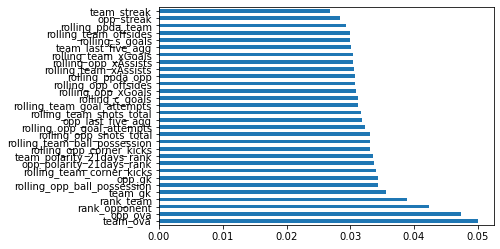

<Figure size 1080x720 with 0 Axes>

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,Y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.figure(figsize = (15,10))
plt.show() #a dopo. ciaoo

# ML Models

Multiple models have been trained with the aim to compare between them to see which one performs best

In [ ]:
matches_df = pd.read_json("./data/matches_new.json")

In [ ]:
scores = pd.read_json("./data/scores2.json")

In [ ]:
league_df = pd.read_json('./data/league_final_with_polarities_rank_bias.json')

In [ ]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

def get_date_range(date,range):
    delta = datetime.timedelta(days=range)
    date_from = date - delta
    return date_from

def split_cols(df, cols):

  for j in range(len(cols)):
    df[[f'{cols[j]}{i}' for i in range(1,6)]] = pd.DataFrame(df[cols[j]].tolist(), index= df.index)
  return df

def createXY(league_df, season=0):
  dataset = league_df.dropna()
  #cols = league_df.columns[14:len(league_df.columns)]
  Y = dataset['result_v']
  X = dataset

  X = split_cols(X, ['team_last_five','opp_last_five'])

  X['team_last_five_agg'] = X['team_last_five5']*0.5 + X['team_last_five4']*0.3 + X['team_last_five3']*0.1 + X['team_last_five2']*0.07 + X['team_last_five1']*0.03
  X['opp_last_five_agg'] = X['opp_last_five5']*0.5 + X['opp_last_five4']*0.3 + X['opp_last_five3']*0.1 + X['opp_last_five2']*0.07 + X['opp_last_five1']*0.03

  cols_to_drop = ['ppda_team','ppda_opp','place','result','s_goals','c_goals','season','match_id','date','time','matchday','team','opponent','team_last_five','opp_last_five','team_shots_total','opp_shots_total','team_ball_possession','opp_ball_possession',\
                  'result_v','team_last_five5','team_last_five4','team_last_five3','team_last_five2','team_last_five1','opp_last_five5','opp_last_five4','opp_last_five3','opp_last_five2','opp_last_five1',\
                  'team_xGoals', 'team_xAssists', 'opp_xGoals', 'opp_xAssists', 'team_corner_kicks', 'opp_corner_kicks', 'opp_goal_attempts', 'team_offsides', 'opp_offsides', 'team_goal_attempts','rolling_ppda_opp','rolling_team_offsides','rolling_ppda_team','rolling_opp_offsides',\
                  'rolling_team_shots_total','rolling_opp_shots_total','rolling_team_xAssists','rolling_opp_xAssists']


  if season == 0:
    X = X.drop(cols_to_drop, axis = 1)
    return X,Y

  else:

      cols_to_drop = ['ppda_team','ppda_opp','place','result','s_goals','c_goals','match_id','date','time','matchday','team','opponent','team_last_five','opp_last_five','team_shots_total','opp_shots_total','team_ball_possession','opp_ball_possession',\
                  'result_v','team_last_five5','team_last_five4','team_last_five3','team_last_five2','team_last_five1','opp_last_five5','opp_last_five4','opp_last_five3','opp_last_five2','opp_last_five1',\
                  'team_xGoals', 'team_xAssists', 'opp_xGoals', 'opp_xAssists', 'team_corner_kicks', 'opp_corner_kicks', 'opp_goal_attempts', 'team_offsides', 'opp_offsides', 'team_goal_attempts','rolling_ppda_opp','rolling_team_offsides','rolling_ppda_team','rolling_opp_offsides',\
                  'rolling_team_xAssists','rolling_opp_xAssists']#,'rolling_team_shots_total','rolling_opp_shots_total'
      X = X.drop(cols_to_drop, axis = 1)
      return X,Y

def balanceData(X_train, Y_train):

  nn = False

  try:

    X_combined = pd.concat([X_train,Y_train], axis = 1)
  except TypeError:
    try:
      X_combined = pd.concat([X_train, pd.DataFrame(data=Y_train,columns=['result_v'],index=X_train.index)], axis = 1)
    except ValueError:
      Y_train = ohe.inverse_transform(Y_train).ravel()
      X_combined = pd.concat([X_train, pd.DataFrame(data=Y_train,columns=['result_v'],index=X_train.index)], axis = 1)
      nn = True


  if 2 not in X_combined.result_v.values:
    won_games = X_combined[X_combined.result_v == 1]
    draw_games = X_combined[X_combined.result_v == 0]
    lost_games = X_combined[X_combined.result_v == -1]
  else:
    won_games = X_combined[X_combined.result_v == 2]
    draw_games = X_combined[X_combined.result_v == 1]
    lost_games = X_combined[X_combined.result_v == 0]

  draw_unsampled = resample(draw_games,
                            replace=True,
                            n_samples=len(won_games),
                            random_state=42)

  final_X = pd.concat([won_games, draw_unsampled,lost_games])

  Y_train = final_X['result_v']

  if nn:
    Y_train = ohe.transform(np.asarray(final_X['result_v']).astype('float32').reshape((-1,1))).toarray()

  X_train = final_X.drop(['result_v'], axis = 1)

  return X_train,Y_train,final_X

def getTrainTest(league_df, random_state=42):
  X,Y = createXY(league_df)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=random_state)
  X_train,Y_train,final_X = balanceData(X_train,Y_train)
  return X_train,Y_train,X_test,Y_test,final_X


def getTrainTestSeason(league_df, season):
  X,Y  = createXY(league_df, season)

  X_train = X[X.season != season]
  Y_train = Y.loc[X_train.index]

  X_test = X[X.season == season]
  Y_test = Y.loc[X_test.index]

  X_train,Y_train,_ = balanceData(X_train,Y_train)

  X_train, X_test = X_train.drop('season', axis=1), X_test.drop('season', axis=1)

  return X_train,Y_train,X_test,Y_test


def gridSearch(clf, parameters, cv, X_Train, Y_Train,verbose = 1, n_jobs = 1):

  s_tcv = time.time()

  RandomizedSearchCV(clf, parameters, cv=5, n_jobs=-1, verbose=0, n_iter=1000).fit(X_train,Y_train)  
  
  e_tcv = time.time()
  
  rnd_time = (e_tcv - s_tcv) / 3600 / 5000

  print('To estimate time await in hours, multiply the total number of fits by', rnd_time)
  print()

  s_tcv = time.time()
  clg_grid = GridSearchCV(clf, parameters, cv=cv, n_jobs=n_jobs,verbose = verbose, return_train_score=True)
  clg_grid.fit(X_train,Y_train)

  e_tcv = time.time()

  return clg_grid,e_tcv - s_tcv


#X,Y = createXY(league_df)
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import LabelBinarizer
def nestedCV(classifier, parameters, n_params, X, Y, cb_object=None, K=5, n=random.randint(0,1000000), n_jobs=-1):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  cv_inner = KFold(n_splits=K, shuffle=True, random_state=n)
  cv_outer = KFold(n_splits=K, shuffle=True, random_state=n)
  space = parameters

  # enumerate splits
  y_scores = list()
  y_onehot = list()
  outer_results = list()
  inner_results = list()
  for fold, (train_ix, test_ix) in enumerate(cv_outer.split(X)):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]

    try:
      y_train, y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    except AttributeError:
      y_train, y_test = Y[train_ix], Y[test_ix]

    X_train, y_train,_ = balanceData(X_train,y_train)

    if isinstance(classifier,KerasClassifier):
      search = CustomRandomizedSearchCV(estimator=classifier, param_distributions=space, cv=cv_inner, n_iter=int(n_params*param_combinations(space)))


    else:
      search = RandomizedSearchCV(estimator=classifier, param_distributions=space, cv=cv_inner, n_jobs=n_jobs, verbose=1, n_iter=int(n_params*param_combinations(space)))

    if cb_object != None:
      cb_object.set_test_data((X_test, y_test))

    result = search.fit(X_train, y_train)

    with suppress_stdout():
      try:
        y_scores.append(result.best_estimator_.predict_proba(X_test))
      except AttributeError:
        d = result.decision_function(X_test)
        y_scores.append(np.exp(d) / np.sum(np.exp(d)))



    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot.append(label_binarizer.transform(y_test))


    best_model = result.best_estimator_

    # evaluate model on the hold out dataset
    with suppress_stdout():
      yhat = best_model.predict(X_test)
    # evaluate the model

    acc = accuracy_score(y_test, yhat)
    cl = classification_report(y_test, yhat, output_dict=True)

    precision = cl['macro avg']['precision']
    recall = cl['macro avg']['recall']
    f1 = cl['macro avg']['f1-score']

    inner_results.append((y_test,yhat))
    outer_results.append({'acc' : acc, 'prec' : precision, 'rec':recall, 'f1' : f1})

    print('    >acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    print()

  print('  Accuracy: %.3f (%.3f)' % (statistics.mean([x['acc'] for x in outer_results]), statistics.stdev([x['acc'] for x in outer_results])))
  print('  Precision: %.3f (%.3f)' % (statistics.mean([x['prec'] for x in outer_results]), statistics.stdev([x['prec'] for x in outer_results])))
  print('  Recall: %.3f (%.3f)' % (statistics.mean([x['rec'] for x in outer_results]), statistics.stdev([x['rec'] for x in outer_results])))
  print('  F1 Score: %.3f (%.3f)' % (statistics.mean([x['f1'] for x in outer_results]), statistics.stdev([x['f1'] for x in outer_results])))

  print()


  return inner_results,outer_results,y_scores,y_onehot

def print_confusion_matrices(inner_results, K=5):

  f, axes = plt.subplots(1, K, figsize=(20, 5), sharey='row')
  f.set_dpi(300)
  for i in range(K):
      try:
        cf_matrix = confusion_matrix(inner_results[i][0], inner_results[i][1])
        #cf_matrix = np.nan_to_num(cf_matrix / cf_matrix.astype(float).sum(axis=0))
      except ValueError: 
        inner_y1 = np.argmax(inner_results[i][0], axis=1)
        inner_y2 = np.argmax(inner_results[i][1], axis=1)
        cf_matrix = confusion_matrix(inner_y1, inner_y2)
        #cf_matrix = np.nan_to_num(cf_matrix / cf_matrix.astype(float).sum(axis=0))

      disp = ConfusionMatrixDisplay(cf_matrix,
                                    display_labels=['Loss','Draw','Win'])
      disp.plot(ax=axes[i], xticks_rotation=45)
      disp.ax_.set_title(f'Confusion matrix {i+1}')
      disp.im_.colorbar.remove()
      disp.ax_.set_xlabel('')
      if i!=0:
          disp.ax_.set_ylabel('')

  f.text(0.4, 0.1, 'Predicted label', ha='left')
  plt.subplots_adjust(wspace=0.20, hspace=0.1)


  f.colorbar(disp.im_, ax=axes)
  plt.show()

def get_mean_confusion_matrices(inner_results, K=5):

  cf_matrix_sum = cf_matrix = np.array([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])

  for i in range(K):
    try:
      cf_matrix = confusion_matrix(inner_results[i][0], inner_results[i][1]) 
      #cf_matrix = np.nan_to_num(cf_matrix / cf_matrix.astype(float).sum(axis=0))
    except ValueError: 
      inner_y1 = np.argmax(inner_results[i][0], axis=1)
      inner_y2 = np.argmax(inner_results[i][1], axis=1)
      cf_matrix = confusion_matrix(inner_y1, inner_y2)
      #cf_matrix = np.nan_to_num(cf_matrix / cf_matrix.astype(float).sum(axis=0))

    cf_matrix_sum += cf_matrix

  #cf_matrix_sum /= K

  return cf_matrix_sum

def print_mean_confusion_matrices_total(matrices):

  cf_matrix_sum = np.array([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])

  for matrix in matrices:
    cf_matrix_sum += matrix

  cf_matrix_sum /= len(matrices) 
  cf_matrix_sum = (np.rint(cf_matrix_sum)).astype(int)
  disp = ConfusionMatrixDisplay(cf_matrix_sum, display_labels=['Loss','Draw','Win'])
  disp.plot(cmap='Blues')

  disp.ax_.set_title("Average confusion matrix")
  plt.figure(figsize=(6,6))
  plt.show()


def param_combinations(dictionary):

  combinations = 1

  for key in dictionary.keys():

    combinations *= len(dictionary[key])

  return combinations



def get_mean_roc(y_scores,y_onehot, K = 5):


  fpr_list = list()
  tpr_list = list()
  for y in range(K):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_onehot[y][:, i], y_scores[y][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    fpr_list.append(fpr_grid)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)


    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      for i in range(3):
        #mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

        interpolator = interp.interp1d(fpr[i], tpr[i], fill_value="extrapolate",assume_sorted = False)
        mean_tpr += [ 0 if math.isnan(p) else p for p in interpolator(fpr_grid)]

      

      #print(np.interp(fpr_grid, fpr[i], tpr[i])[0])
    # Average it and compute AUC
    mean_tpr /= 3

    tpr_list.append(mean_tpr)


  sum_fpr = np.zeros_like(fpr_grid)
  sum_tpr = np.zeros_like(fpr_grid)
  for fpr in fpr_list:
    sum_fpr += fpr

  mean_fpr = sum_fpr / len(fpr_list)

  for tpr in tpr_list:
    sum_tpr += tpr

  mean_tpr = sum_tpr / len(tpr_list)
  auc_mean = auc(mean_fpr, mean_tpr)
  
  return (mean_fpr,mean_tpr,auc_mean)

def print_ROC(roc_curves):

  fpr = np.zeros_like(roc_curves[0][0])
  tpr = np.zeros_like(roc_curves[0][0])
  auc = 0
  for i in range(len(roc_curves)):
    fpr += roc_curves[i][0]
    tpr += roc_curves[i][1]
    auc += roc_curves[i][2]

  mean_fpr = fpr/len(roc_curves)
  mean_tpr = tpr/len(roc_curves)
  mean_auc = auc/len(roc_curves)

  plt.figure(figsize=(6,6))
  plt.plot(\
      mean_fpr,\
      mean_tpr,\
      label=f"macro-average ROC curve (AUC = {mean_auc:.2f})",\
      color="navy",\
      linewidth=4,\
  )
  plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Average One-vs-Rest ROC curve")
  plt.legend()
  plt.show()

class TestCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        self.best_weights = None
        self.best_acc = 0
        self.best_epoch = 0
   
    def set_keras_classifier(self, keras_classifier):
        self.keras_classifier = keras_classifier
 
    def on_epoch_end(self, epoch, logs):        

        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['test_accuracy'] = acc

        #find best model
        if acc > self.best_acc:
          self.best_epoch = epoch
          self.best_acc = acc
          self.best_weights = self.model.get_weights()

        gc.collect()
        k.clear_session()
        

    def on_train_end(self, logs=None):
        self.keras_classifier.model_.set_weights(self.best_weights)
        self.keras_classifier.best_epoch = self.best_epoch

    def set_test_data(self, test_data):
        self.test_data = test_data


class CustomRandomizedSearchCV:

  def __init__(self, estimator, param_distributions, cv, n_iter):

    self.estimator = estimator  #questo è un KerasClassifier
    self.param_distributions = param_distributions
    self.cv = cv
    self.n_iter = n_iter
    self.best_estimator_ = None
    self.best_score_ = 0
    self.best_params_ = 0

  @staticmethod
  def param_combinations(dictionary):

    combinations = 1

    for key in dictionary.keys():

      combinations *= len(dictionary[key])

    return combinations


  @staticmethod
  def params_permutations(param_distributions):

    perms = [[] for i in range(param_combinations(param_distributions))]

    tmp = [list(zip(param_distributions, v)) for v in product(*param_distributions.values())]

    k = 0

    for i in tmp:
      for j in i:
        perms[k].append(j[1])
      k+=1

    random.shuffle(perms)

    return perms


  def fit(self, X, Y):

    with suppress_stdout():

      params = self.params_permutations(self.param_distributions)[:self.n_iter]  
      self.accuracy_list = []

      for param_set in params:

        for train_ix, test_ix in self.cv.split(X):
          # split data
          X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
          y_train, y_test = Y[train_ix], Y[test_ix]

          self.estimator.fit(X_train, y_train, epochs=param_set[0], batch_size=param_set[1], verbose=0) 

          self.accuracy_list.append( ([self.estimator.best_epoch,param_set[1]], self.estimator.score(X_test, y_test), self.estimator.score(X_train, y_train)) )

      max_acc = 0
      for element in self.accuracy_list:
        if element[1] > max_acc:
          max_acc = element[1]
          best_model = element[0]

      self.best_score_ = max_acc
      self.best_params_ = " ".join([str(x) for x in best_model])
      #self.best_params_ = best_model

      self.estimator.fit(X, Y, epochs=best_model[0], batch_size=best_model[1], verbose=0)

      self.best_estimator_ = self.estimator

      return self
        




## Columns selection

In [ ]:
#drop all polarities

def no_polarities(X_train, X_test):

  cols_to_drop =  ['team_polarity_new_7', \
                  'opp_polarity_new_7', 'team_polarity_new_7_rank', \
                  'opp_polarity_new_7_rank', 'team_polarity_new_14', \
                  'opp_polarity_new_14', 'team_polarity_new_14_rank', \
                  'opp_polarity_new_14_rank', 'team_polarity_new_21', \
                  'opp_polarity_new_21', 'team_polarity_new_21_rank', \
                  'opp_polarity_new_21_rank', 'team_polarity_7days', \
                  'opp_polarity_7days', 'team_polarity_14days', \
                  'opp_polarity_14days', 'team_polarity_21days', \
                  'opp_polarity_21days', 'team_polarity_alldays', \
                  'opp_polarity_alldays', 'team_polarity_7days_rank', \
                  'opp_polarity_7days_rank', 'team_polarity_14days_rank', \
                  'opp_polarity_14days_rank', 'team_polarity_21days_rank', \
                  'opp_polarity_21days_rank', 'team_polarity_alldays_rank', \
                  'opp_polarity_alldays_rank','team_polarity_new_7_bias', \
                  'opp_polarity_new_7_bias', 'team_polarity_new_7_rank_bias', \
                  'opp_polarity_new_7_rank_bias', 'team_polarity_new_14_bias', \
                  'opp_polarity_new_14_bias', 'team_polarity_new_14_rank_bias', \
                  'opp_polarity_new_14_rank_bias', 'team_polarity_new_21_bias', \
                  'opp_polarity_new_21_bias', 'team_polarity_new_21_rank_bias', \
                  'opp_polarity_new_21_rank_bias']


  X_train = X_train.drop(cols_to_drop, axis=1)
  X_test = X_test.drop(cols_to_drop, axis=1)

  return X_train,X_test


In [ ]:
#keep old polarities

def old_polarities(X_train, X_test):

  cols_to_drop =  ['team_polarity_new_7', \
                  'opp_polarity_new_7', 'team_polarity_new_7_rank', \
                  'opp_polarity_new_7_rank', 'team_polarity_new_14', \
                  'opp_polarity_new_14', 'team_polarity_new_14_rank', \
                  'opp_polarity_new_14_rank', 'team_polarity_new_21', \
                  'opp_polarity_new_21', 'team_polarity_new_21_rank', \
                  'opp_polarity_new_21_rank', 'team_polarity_7days', \
                  'opp_polarity_7days', 'team_polarity_14days', \
                  'opp_polarity_14days', 'team_polarity_21days', \
                  'opp_polarity_21days', 'team_polarity_alldays', \
                  'opp_polarity_alldays', 'team_polarity_7days_rank', \
                  'opp_polarity_7days_rank', 'team_polarity_14days_rank', \
                  'opp_polarity_14days_rank', \
                  'team_polarity_alldays_rank', \
                  'opp_polarity_alldays_rank','team_polarity_new_7_bias', \
                  'opp_polarity_new_7_bias', 'team_polarity_new_7_rank_bias', \
                  'opp_polarity_new_7_rank_bias', 'team_polarity_new_14_bias', \
                  'opp_polarity_new_14_bias', 'team_polarity_new_14_rank_bias', \
                  'opp_polarity_new_14_rank_bias', 'team_polarity_new_21_bias', \
                  'opp_polarity_new_21_bias', 'team_polarity_new_21_rank_bias', \
                  'opp_polarity_new_21_rank_bias']


  X_train = X_train.drop(cols_to_drop, axis=1)
  X_test = X_test.drop(cols_to_drop, axis=1)

  return X_train,X_test



In [ ]:
#keep new polarities

def new_polarities(X_train, X_test):

  cols_to_drop =  ['team_polarity_new_7', \
                  'opp_polarity_new_7', 'team_polarity_new_7_rank', \
                  'opp_polarity_new_7_rank', 'team_polarity_new_14', \
                  'opp_polarity_new_14', 'team_polarity_new_14_rank', \
                  'opp_polarity_new_14_rank', \
                  'team_polarity_new_21_rank', \
                  'opp_polarity_new_21_rank', 'team_polarity_7days', \
                  'opp_polarity_7days', 'team_polarity_14days', \
                  'opp_polarity_14days', 'team_polarity_21days', \
                  'opp_polarity_21days', 'team_polarity_alldays', \
                  'opp_polarity_alldays', 'team_polarity_7days_rank', \
                  'opp_polarity_7days_rank', 'team_polarity_14days_rank', \
                  'opp_polarity_14days_rank', 'team_polarity_21days_rank', \
                  'opp_polarity_21days_rank', 'team_polarity_alldays_rank', \
                  'opp_polarity_alldays_rank','team_polarity_new_7_bias', \
                  'opp_polarity_new_7_bias', 'team_polarity_new_7_rank_bias', \
                  'opp_polarity_new_7_rank_bias', 'team_polarity_new_14_bias', \
                  'opp_polarity_new_14_bias', 'team_polarity_new_14_rank_bias', \
                  'opp_polarity_new_14_rank_bias', 'team_polarity_new_21_rank', \
                  'opp_polarity_new_21_rank', 'team_polarity_new_21_rank_bias', \
                  'opp_polarity_new_21_rank_bias','team_polarity_new_21','opp_polarity_new_21']


  X_train = X_train.drop(cols_to_drop, axis=1)
  X_test = X_test.drop(cols_to_drop, axis=1)

  return X_train,X_test


In [ ]:
def old_polarities_only(X_train, X_test):


  cols = ['team_polarity_21days_rank','opp_polarity_21days_rank']

  X_train = X_train[cols]
  X_test = X_test[cols]

  return X_train, X_test

In [ ]:
def new_polarities_only(X_train, X_test):


  cols = ['team_polarity_new_21_rank_bias','opp_polarity_new_21_rank_bias']

  X_train = X_train[cols]
  X_test = X_test[cols]

  return X_train, X_test

## Decision Tree

In [ ]:
space = {
    'max_depth' : [x for x in range(3,10)],
    'min_samples_split' : [x for x in range(2,40,5)],
    'min_samples_leaf' : [10, 20, 0.1, 0.2, 0.3],
    'max_features' : [None,'sqrt','log2',0.9,0.8,0.6],
    }
classifier = tree.DecisionTreeClassifier()

### Polarities + Statistical data

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))

print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.466(0.013) Precision: 0.448(0.006) Recall: 0.438(0.009) F1 Score: 0.439(0.007)


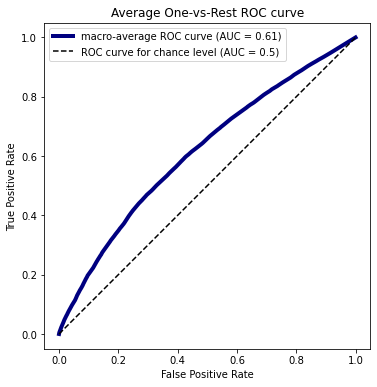

In [ ]:
print_ROC(roc_curves)

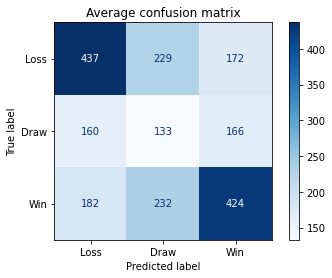

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata


#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

In [ ]:
X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.476(0.007) Precision: 0.454(0.005) Recall: 0.449(0.006) F1 Score: 0.448(0.006)


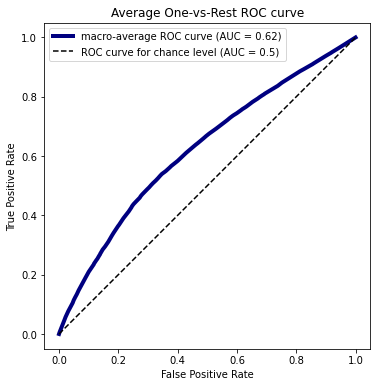

In [ ]:
print_ROC(roc_curves)

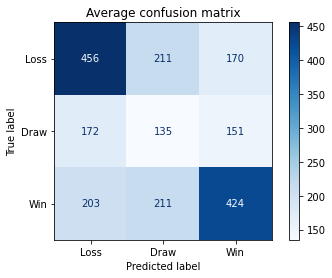

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata

### Polarities only

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.436(0.013) Precision: 0.435(0.012) Recall: 0.423(0.012) F1 Score: 0.418(0.012)


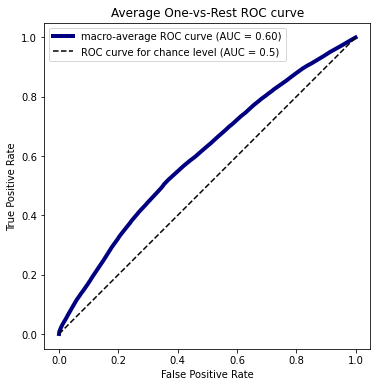

In [ ]:
print_ROC(roc_curves)

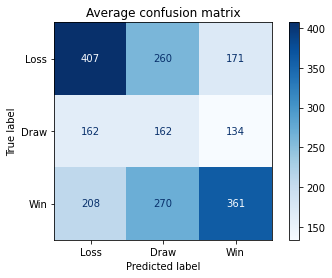

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata


#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.461(0.011) Precision: 0.446(0.007) Recall: 0.438(0.009) F1 Score: 0.437(0.009)


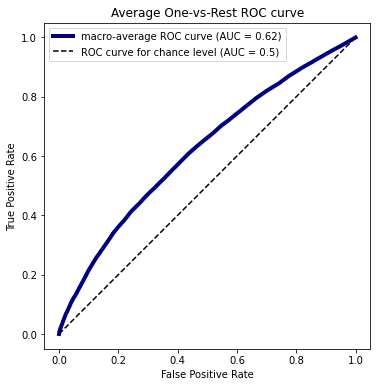

In [ ]:
print_ROC(roc_curves)

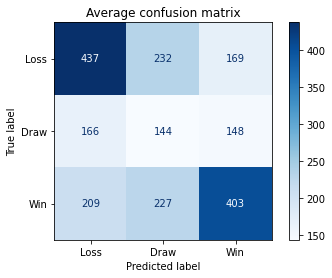

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) 

## Random Forest

In [ ]:
space = {
    'n_estimators' : [100, 120, 150, 180, 200],
    'max_depth' : [x for x in range(3,10)],
    'min_samples_split' : [x for x in range(2,40,5)],
    'min_samples_leaf' : [10, 20, 0.1, 0.2, 0.3],
    'max_features' : [None,'sqrt','log2',0.9,0.8,0.7]
}

classifier = RandomForestClassifier()

### Polarities + Statistical data

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 0.1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')

RESULTS: Accuracy: 0.546(0.007) Precision: 0.483(0.012) Recall: 0.490(0.010) F1 Score: 0.481(0.011)


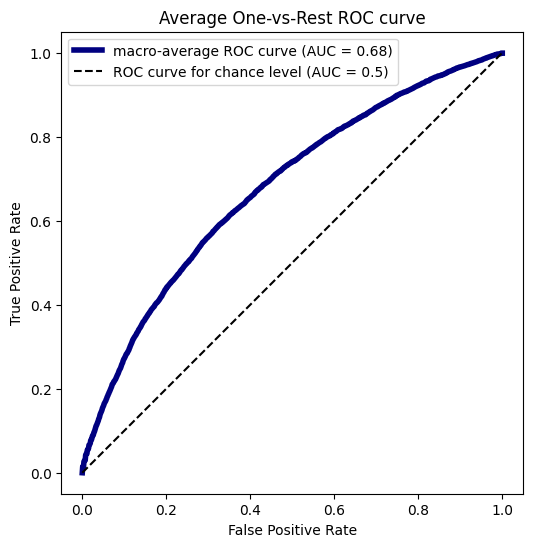

In [ ]:
print_ROC(roc_curves)

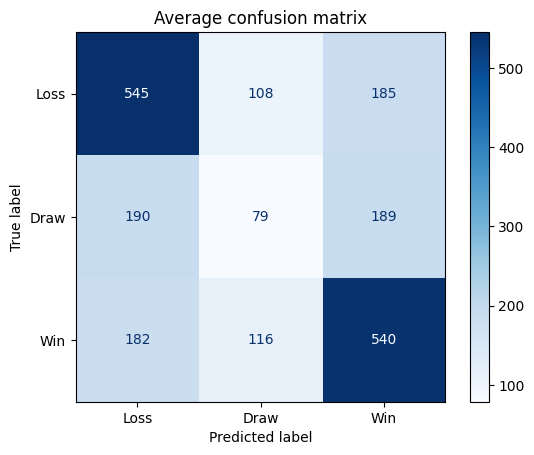

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata


#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 0.1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.541(0.003) Precision: 0.480(0.006) Recall: 0.486(0.005) F1 Score: 0.478(0.006)


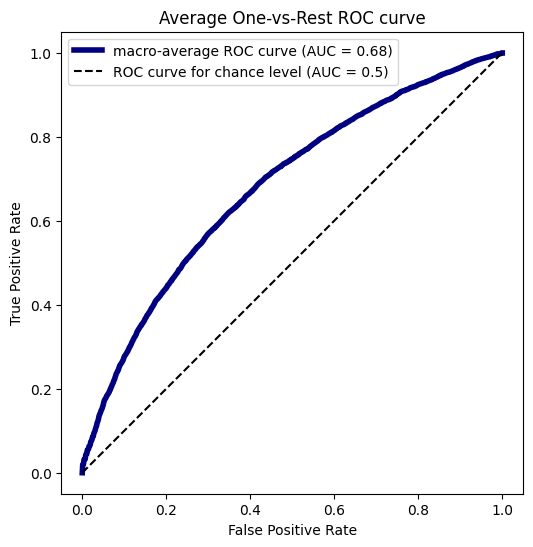

In [ ]:
print_ROC(roc_curves)

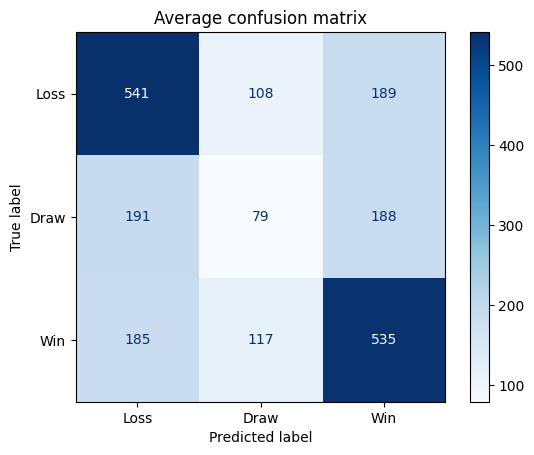

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata


### Polarities only

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 0.1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare 

RESULTS: Accuracy: 0.474(0.008) Precision: 0.446(0.009) Recall: 0.443(0.010) F1 Score: 0.443(0.010)


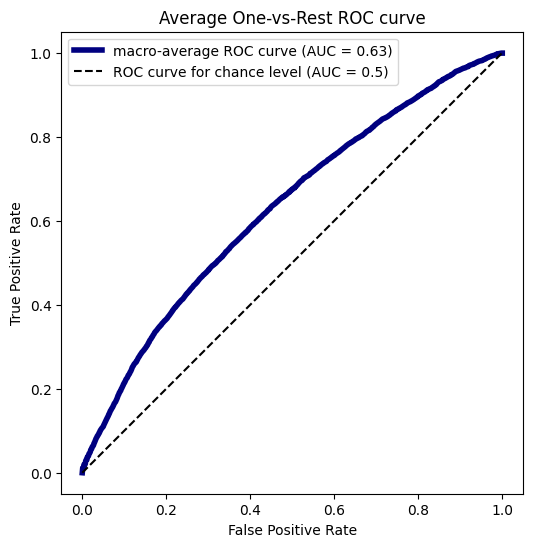

In [ ]:
print_ROC(roc_curves)

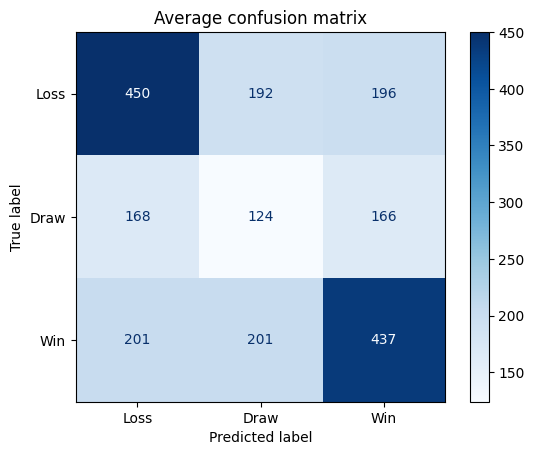

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata


#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 0.01, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.482(0.005) Precision: 0.448(0.006) Recall: 0.446(0.006) F1 Score: 0.446(0.006)


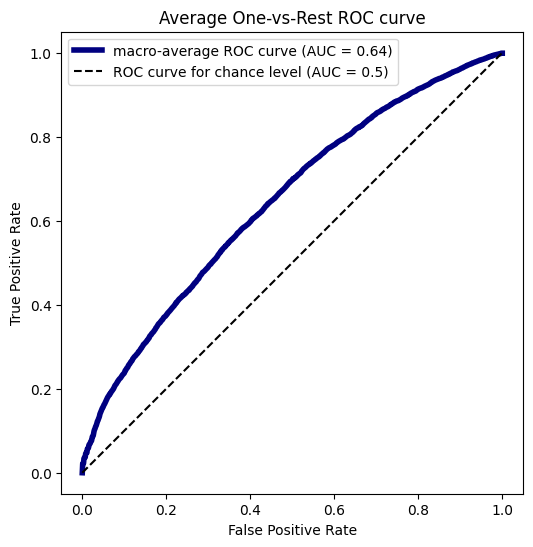

In [ ]:
print_ROC(roc_curves)

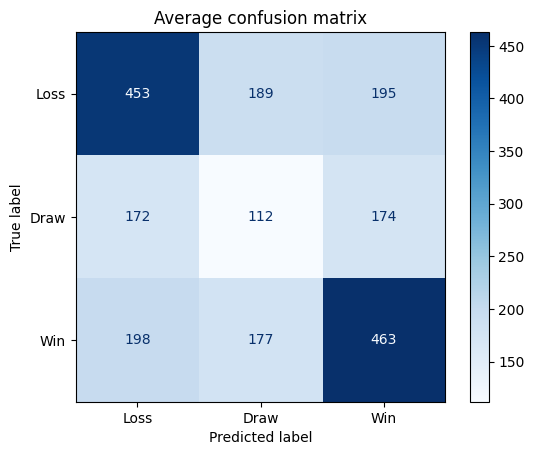

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) 

## Xg Boost

In [ ]:
space = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8]
        }

classifier = XGBClassifier()
le = LabelEncoder()

### Polarities + Statistical data

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

Y = le.fit_transform(Y)

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 0.5, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.531(0.005) Precision: 0.456(0.006) Recall: 0.467(0.005) F1 Score: 0.451(0.005)


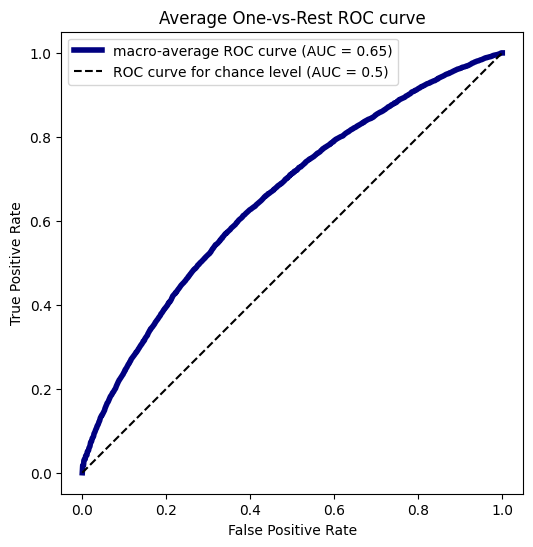

In [ ]:
print_ROC(roc_curves)

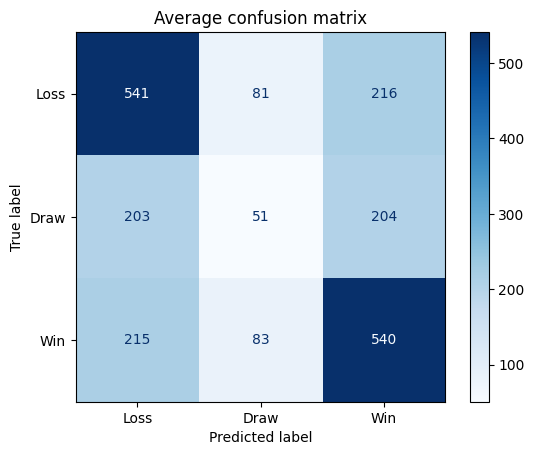

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata


#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])
X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

Y = le.fit_transform(Y)

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot = nestedCV(classifier, space, 0.5, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.535(0.003) Precision: 0.458(0.006) Recall: 0.471(0.003) F1 Score: 0.454(0.005)


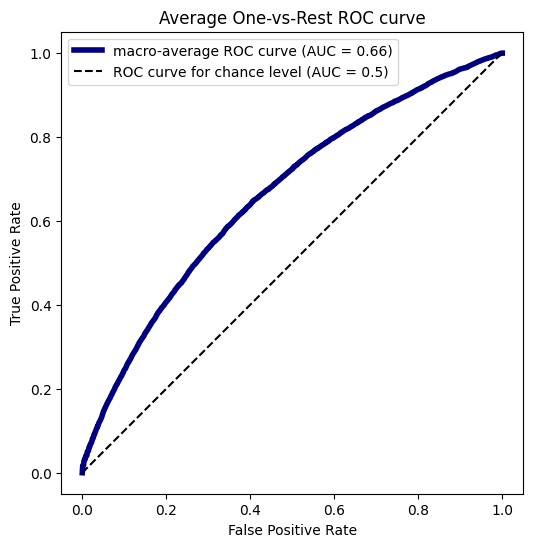

In [ ]:
print_ROC(roc_curves)

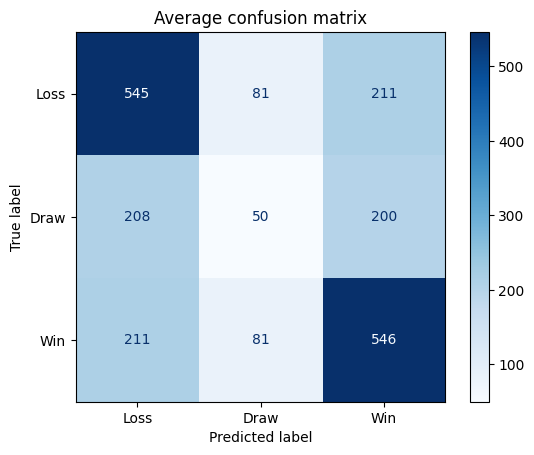

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata


### Polarities only

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])
X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

Y = le.fit_transform(Y)

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.466(0.009) Precision: 0.426(0.011) Recall: 0.427(0.009) F1 Score: 0.424(0.009)


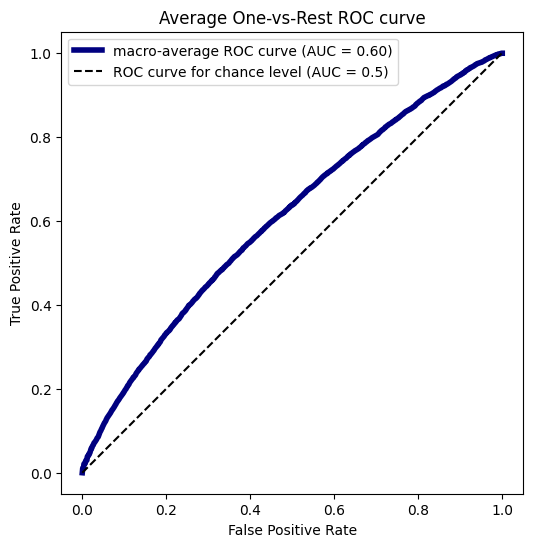

In [ ]:
print_ROC(roc_curves)

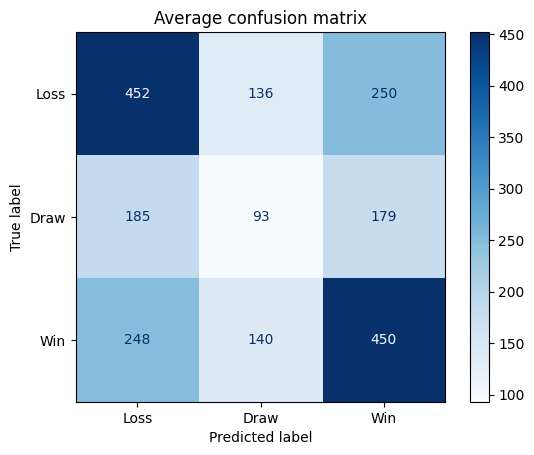

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata


#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])
X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

Y = le.fit_transform(Y)

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.482(0.008) Precision: 0.434(0.009) Recall: 0.438(0.008) F1 Score: 0.433(0.009)


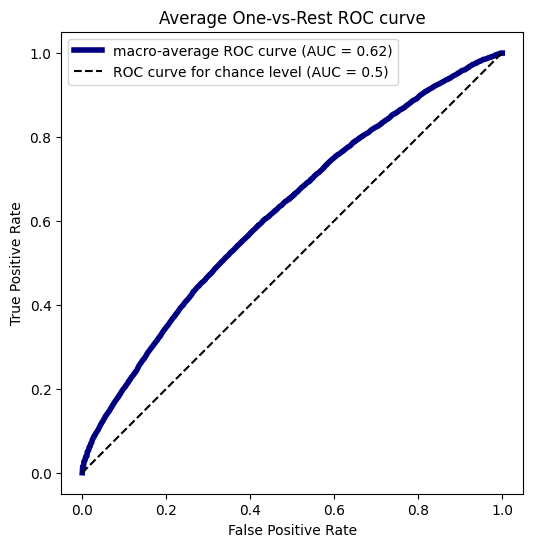

In [ ]:
print_ROC(roc_curves)

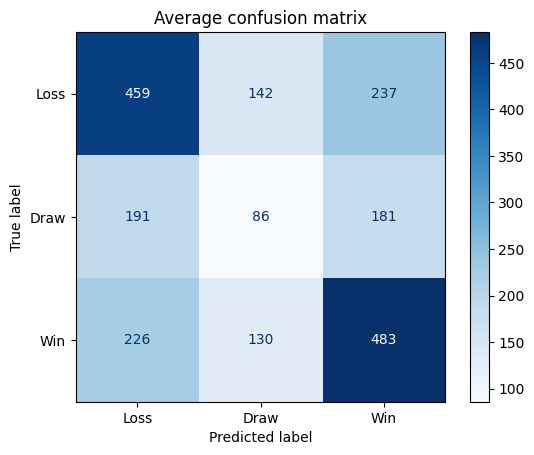

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) 

## K-Nearest Neighbor

In [ ]:
space = {
    'n_neighbors': [x for x in range(5,100,5)],
    'weights': ['uniform','distance'],
    'algorithm' : ['auto'],
    'leaf_size' : [10,20,30,40,50],
    'p': [1,2,3,4],
    'metric': ['minkowski']
}

classifier = KNeighborsClassifier()


### Polarities + Statistical data

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities(X_train,X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i, n_jobs=6)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.510(0.007) Precision: 0.492(0.007) Recall: 0.483(0.008) F1 Score: 0.484(0.008)


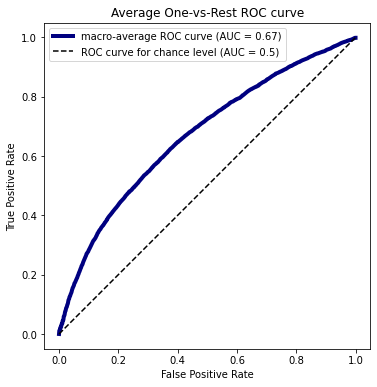

In [ ]:
print_ROC(roc_curves)

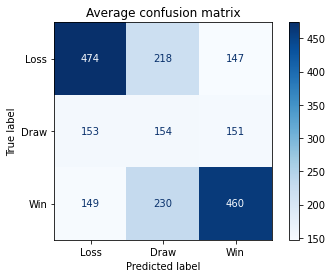

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

In [ ]:
X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i, n_jobs=6)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.512(0.006) Precision: 0.493(0.006) Recall: 0.485(0.006) F1 Score: 0.486(0.006)


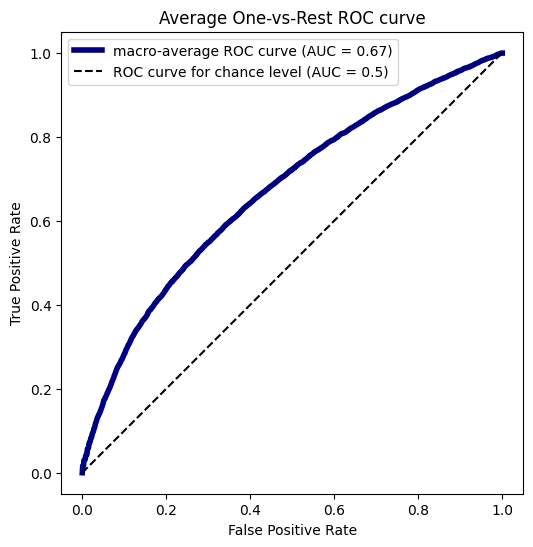

In [ ]:
print_ROC(roc_curves)

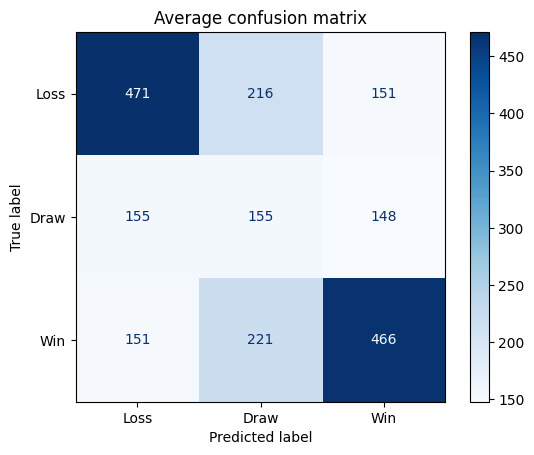

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

### Polarities only

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i, n_jobs=6)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.477(0.008) Precision: 0.456(0.008) Recall: 0.451(0.009) F1 Score: 0.452(0.008)


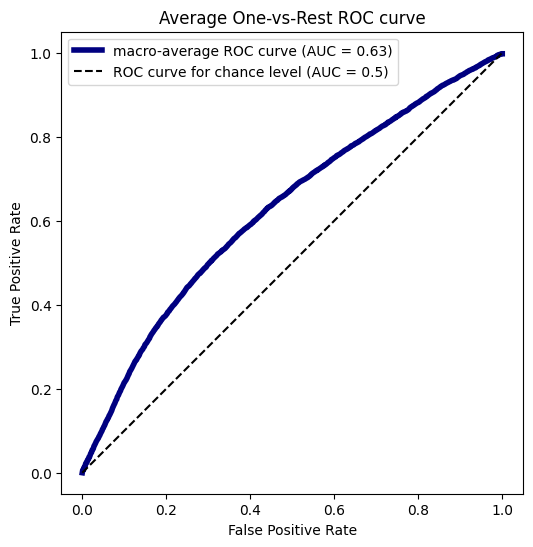

In [ ]:
print_ROC(roc_curves)

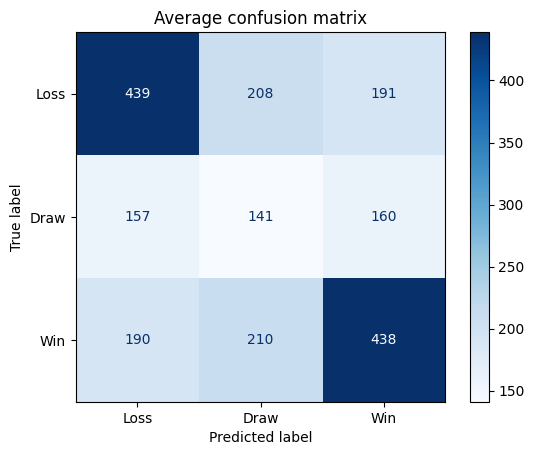

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 0.01, X, Y, n=i, n_jobs=6)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.478(0.002) Precision: 0.445(0.007) Recall: 0.443(0.005) F1 Score: 0.443(0.006)


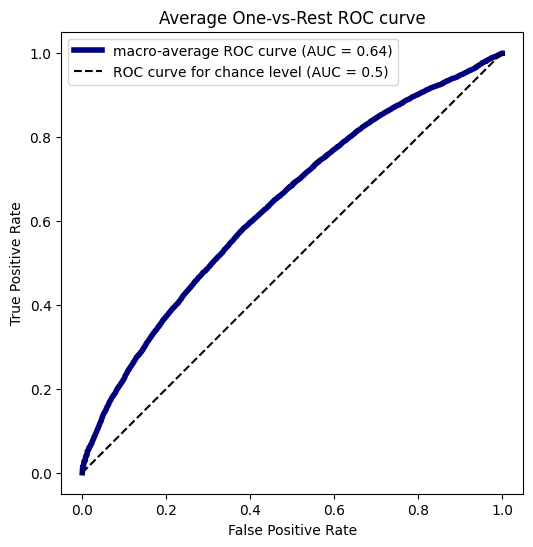

In [ ]:
print_ROC(roc_curves)

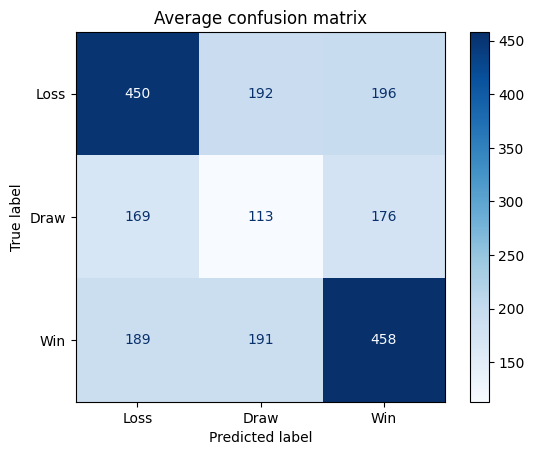

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

## Neural networks

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
space = { 
              'epochs': [125],
              'batch_size' : [16,24,32]
            }

#with tf.device('/device:GPU:0'):

def create_model(X):



  model = Sequential()
  model.add(Dense(12, input_dim=X.shape[1], activation='sigmoid')) 
  model.add(Dense(8, activation='sigmoid')) 
  model.add(Dense(4, activation='sigmoid')) 
  model.add(Dense(3, activation='softmax'))

  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model


### Polarities + Statistical data

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)
X_train,X_test = old_polarities(X_train,X_test)

X_train_norm = (X_train-X_train.mean())/X_train.std()
X_test_norm = (X_test-X_test.mean())/X_test.std()

ohe = OneHotEncoder()
Y_train_ohe = ohe.fit_transform(np.asarray(Y_train).astype('float32').reshape((-1,1))).toarray()
Y_test_ohe = ohe.fit_transform(np.asarray(Y_test).astype('float32').reshape((-1,1))).toarray()

X_norm = pd.concat([X_train_norm, X_test_norm])
Y = pd.concat([Y_train, Y_test])

X_norm = X_norm[~X_norm.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

Y_ohe = ohe.fit_transform(np.asarray(Y).astype('float32').reshape((-1,1))).toarray()

In [ ]:
cb_object = TestCallback()
model = KerasClassifier(model=create_model(X_norm), callbacks=cb_object)
cb_object.set_keras_classifier(model)


matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot = nestedCV(model, space, 1, X_norm, Y_ohe, n=i, cb_object=cb_object)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.572(0.004) Precision: 0.519(0.006) Recall: 0.521(0.007) F1 Score: 0.515(0.012)


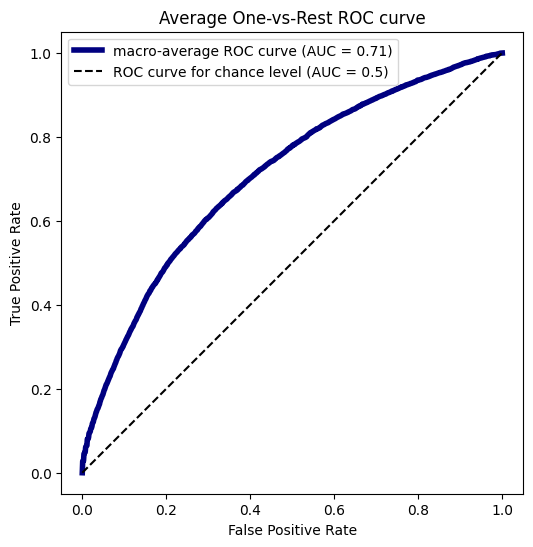

In [ ]:
print_ROC(roc_curves)

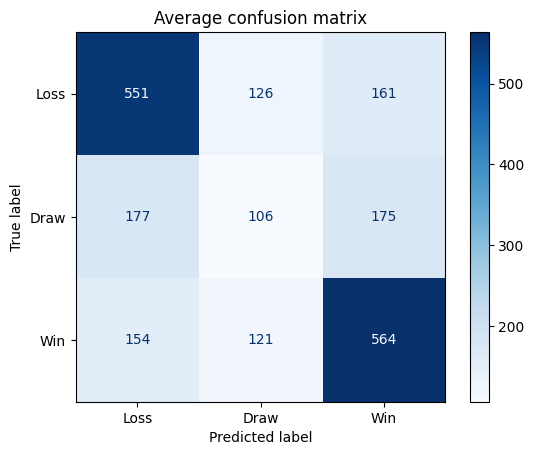

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)
X_train,X_test = new_polarities(X_train,X_test)

X_train_norm = (X_train-X_train.mean())/X_train.std()
X_test_norm = (X_test-X_test.mean())/X_test.std()

ohe = OneHotEncoder()
Y_train_ohe = ohe.fit_transform(np.asarray(Y_train).astype('float32').reshape((-1,1))).toarray()
Y_test_ohe = ohe.fit_transform(np.asarray(Y_test).astype('float32').reshape((-1,1))).toarray()

X_norm = pd.concat([X_train_norm, X_test_norm])
Y = pd.concat([Y_train, Y_test])

X_norm = X_norm[~X_norm.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

Y_ohe = ohe.fit_transform(np.asarray(Y).astype('float32').reshape((-1,1))).toarray()

In [ ]:
cb_object = TestCallback()
model = KerasClassifier(model=create_model(X_norm), callbacks=cb_object)
cb_object.set_keras_classifier(model)


matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot = nestedCV(model, space, 1, X_norm, Y_ohe, n=i, cb_object=cb_object)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.575(0.004) Precision: 0.512(0.007) Recall: 0.514(0.003) F1 Score: 0.502(0.003)


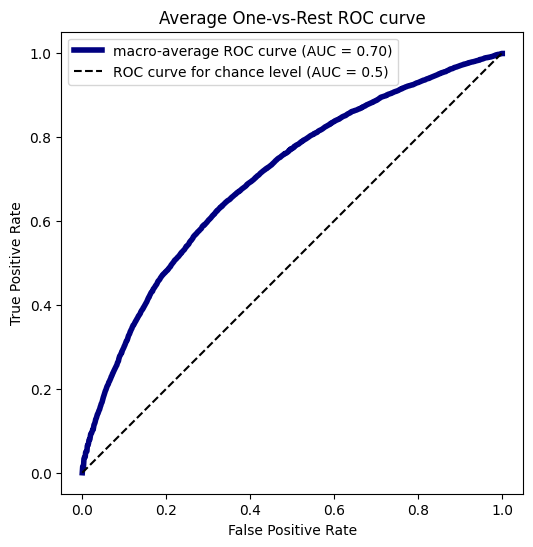

In [ ]:
print_ROC(roc_curves)

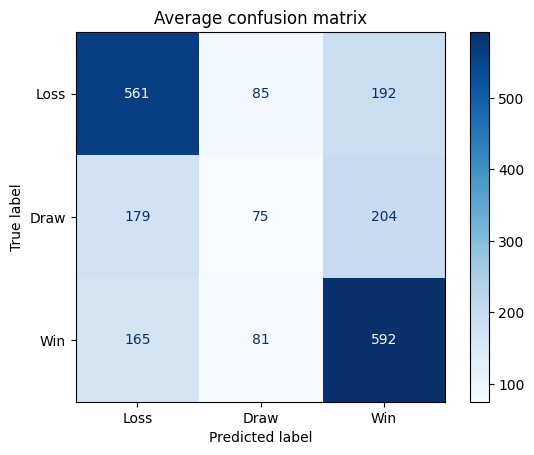

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

### Polarities only

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)
X_train,X_test = old_polarities_only(X_train,X_test)

X_train_norm = (X_train-X_train.mean())/X_train.std()
X_test_norm = (X_test-X_test.mean())/X_test.std()

ohe = OneHotEncoder()
Y_train_ohe = ohe.fit_transform(np.asarray(Y_train).astype('float32').reshape((-1,1))).toarray()
Y_test_ohe = ohe.fit_transform(np.asarray(Y_test).astype('float32').reshape((-1,1))).toarray()

X_norm = pd.concat([X_train_norm, X_test_norm])
Y = pd.concat([Y_train, Y_test])

X_norm = X_norm[~X_norm.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

Y_ohe = ohe.fit_transform(np.asarray(Y).astype('float32').reshape((-1,1))).toarray()

In [ ]:

cb_object = TestCallback()
model = KerasClassifier(model=create_model(X_norm), callbacks=cb_object)
cb_object.set_keras_classifier(model)


matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []



for i in range(5):
  inner_results, outer_results, y_scores, y_onehot = nestedCV(model, space, 1, X_norm, Y_ohe, n=i, cb_object=cb_object)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.517(0.004) Precision: 0.456(0.019) Recall: 0.455(0.003) F1 Score: 0.439(0.002)


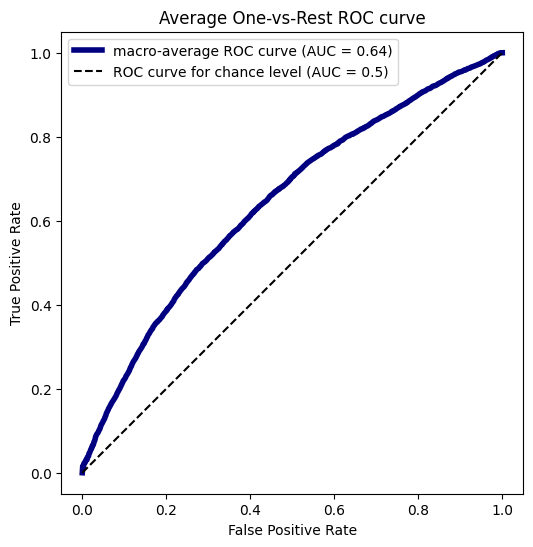

In [ ]:
print_ROC(roc_curves)

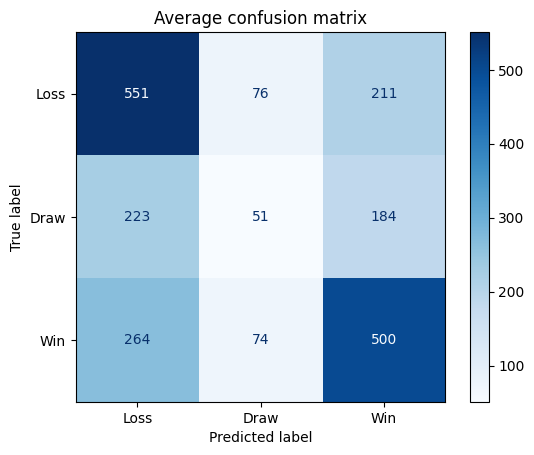

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)
X_train,X_test = new_polarities_only(X_train,X_test)

X_train_norm = (X_train-X_train.mean())/X_train.std()
X_test_norm = (X_test-X_test.mean())/X_test.std()

ohe = OneHotEncoder()
Y_train_ohe = ohe.fit_transform(np.asarray(Y_train).astype('float32').reshape((-1,1))).toarray()
Y_test_ohe = ohe.fit_transform(np.asarray(Y_test).astype('float32').reshape((-1,1))).toarray()

X_norm = pd.concat([X_train_norm, X_test_norm])
Y = pd.concat([Y_train, Y_test])

X_norm = X_norm[~X_norm.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

Y_ohe = ohe.fit_transform(np.asarray(Y).astype('float32').reshape((-1,1))).toarray()

In [ ]:
cb_object = TestCallback()
model = KerasClassifier(model=create_model(X_norm), callbacks=cb_object)
cb_object.set_keras_classifier(model)


matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(model, space, 1, X_norm, Y_ohe, n=i, cb_object=cb_object)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.516(0.001) Precision: 0.465(0.003) Recall: 0.469(0.002) F1 Score: 0.465(0.003)


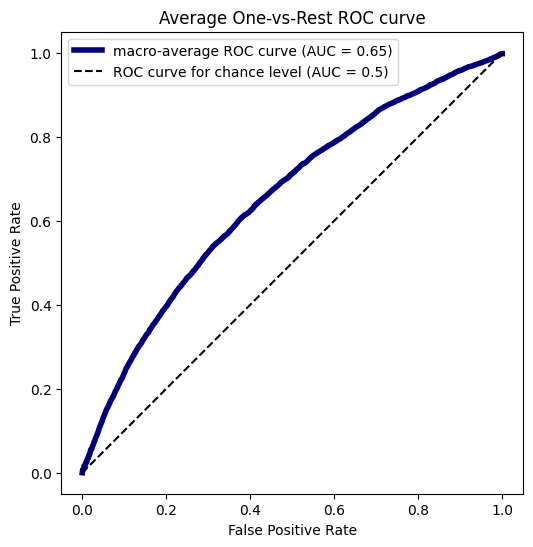

In [ ]:
print_ROC(roc_curves)

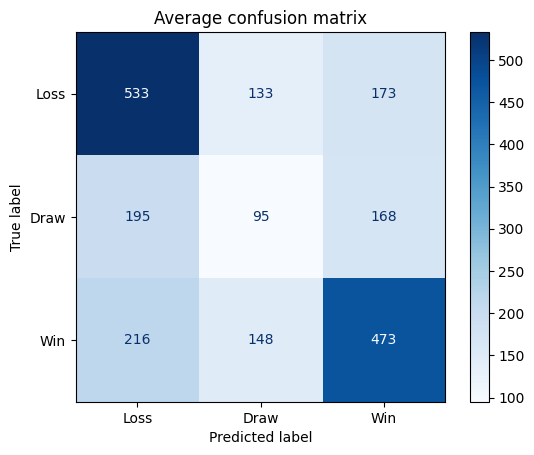

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

## Ridge Regression

In [ ]:
space = {
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
  'fit_intercept': [True, False],
  'max_iter': [None] + [x for x in range(1,10,2)],
  'solver' : ['auto']
}

classifier = RidgeClassifier()

### Polarities + Statistical data

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities(X_train,X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.546(0.008) Precision: 0.482(0.006) Recall: 0.490(0.006) F1 Score: 0.483(0.005)


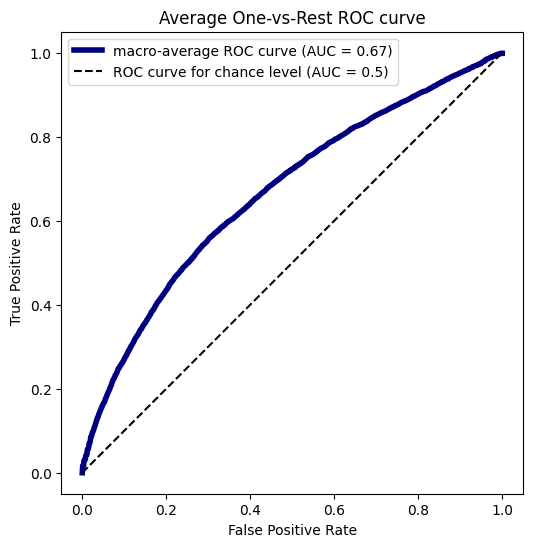

In [ ]:
print_ROC(roc_curves)

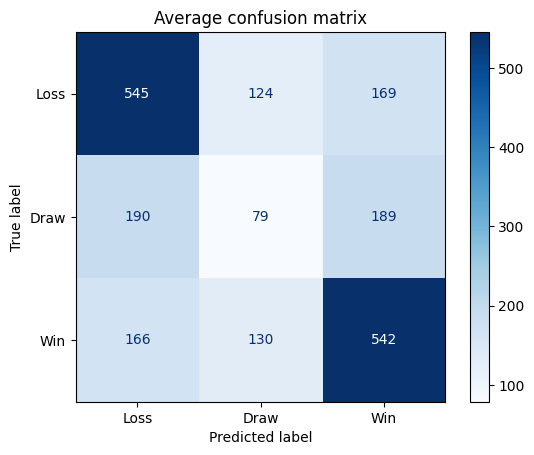

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata

#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities(X_train,X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.550(0.005) Precision: 0.482(0.009) Recall: 0.492(0.006) F1 Score: 0.483(0.008)


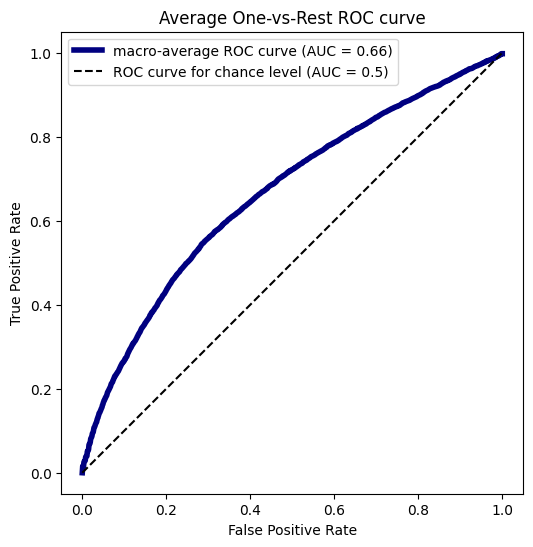

In [ ]:
print_ROC(roc_curves)

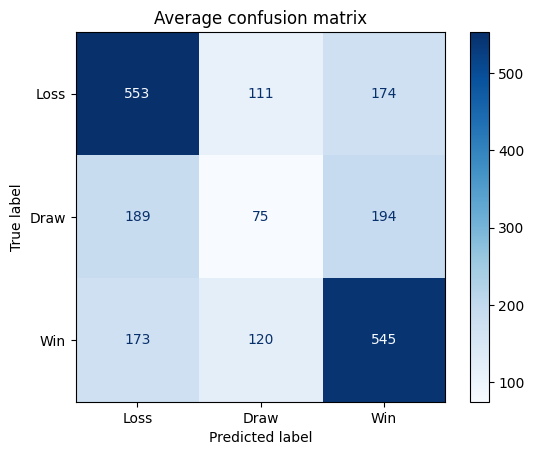

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices) #non non l'ho provata

### Polarities only

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.498(0.005) Precision: 0.433(0.014) Recall: 0.445(0.004) F1 Score: 0.432(0.011)


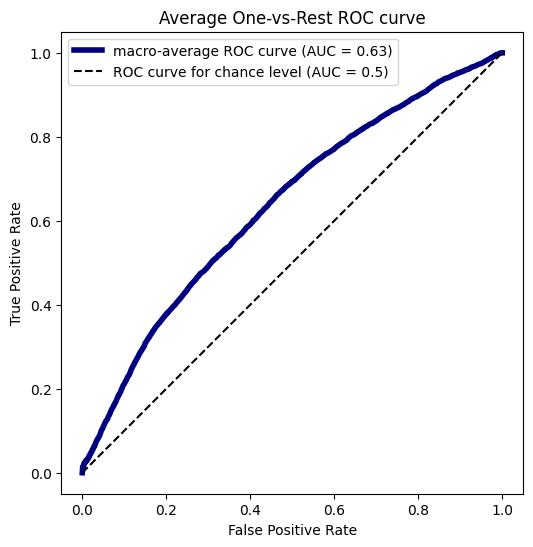

In [ ]:
print_ROC(roc_curves)

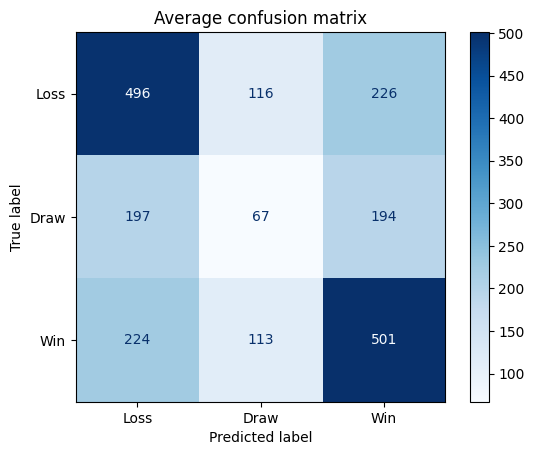

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.498(0.008) Precision: 0.431(0.017) Recall: 0.450(0.003) F1 Score: 0.432(0.011)


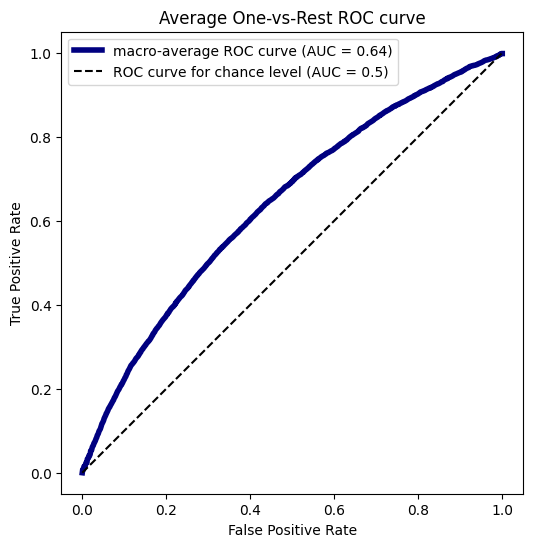

In [ ]:
print_ROC(roc_curves)

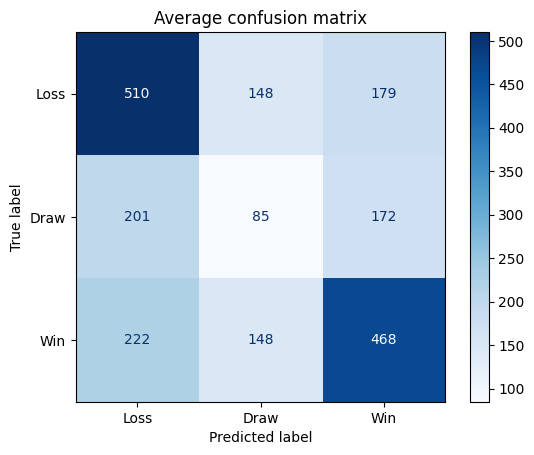

<Figure size 600x600 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

## Support Vector Machines

In [ ]:
space = {
    'decision_function_shape' : ['ovo','ovr'],
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
    'probability' : [True]
}

classifier = SVC()

### Polarities + Statistical data

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities(X_train,X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.459(0.007) Precision: 0.417(0.009) Recall: 0.417(0.008) F1 Score: 0.413(0.008)


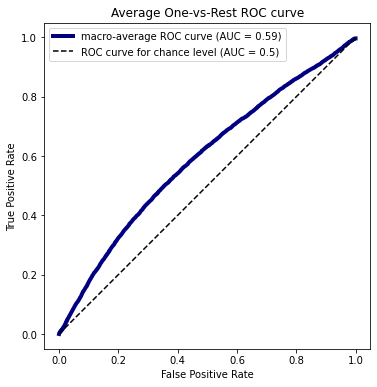

In [ ]:
print_ROC(roc_curves)

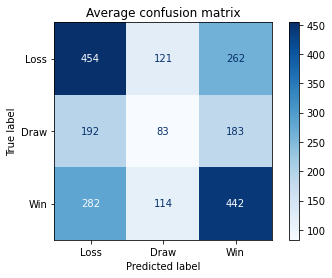

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities(X_train,X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

In [ ]:
X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.477(0.006) Precision: 0.428(0.007) Recall: 0.430(0.005) F1 Score: 0.425(0.006)


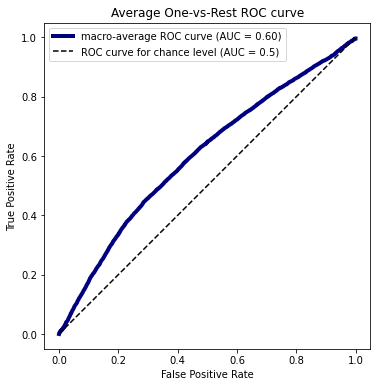

In [ ]:
print_ROC(roc_curves)

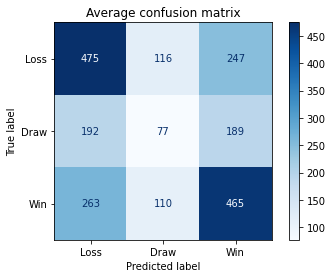

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

### Polarities only

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.459(0.004) Precision: 0.461(0.008) Recall: 0.448(0.006) F1 Score: 0.445(0.005)


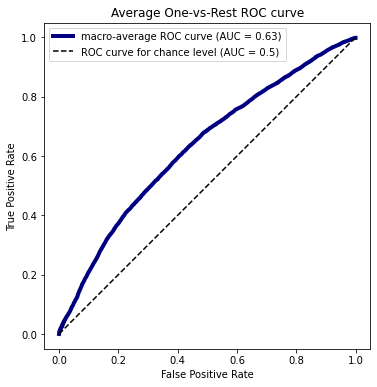

In [ ]:
print_ROC(roc_curves)

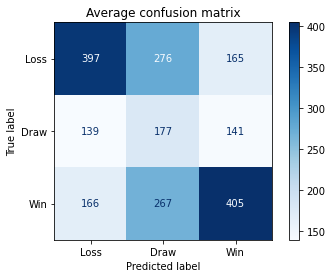

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.477(0.009) Precision: 0.464(0.004) Recall: 0.454(0.004) F1 Score: 0.454(0.004)


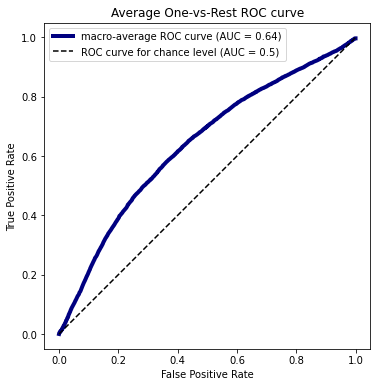

In [ ]:
print_ROC(roc_curves)

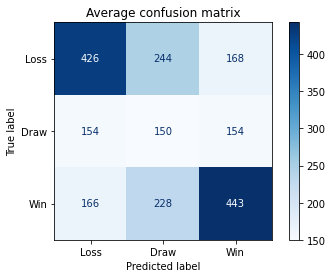

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
space = {
    'solver' : ['lbfgs'],
    'penalty' : ['l2'],
    'C': [0.1, 1, 10, 100, 1000], 
    'tol' : [0.0001, 0.001, 0.01, 0.1, 1],
    'max_iter' : [10000]
}

classifier = LogisticRegression()

### Polarities + Statistical data

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities(X_train,X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.532(0.002) Precision: 0.491(0.004) Recall: 0.489(0.004) F1 Score: 0.489(0.004)


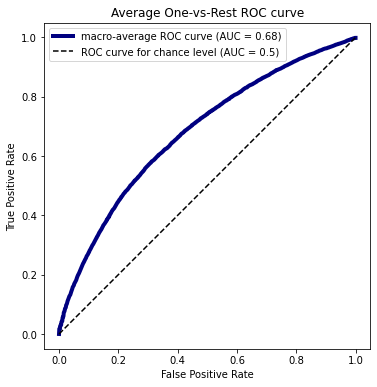

In [ ]:
print_ROC(roc_curves)

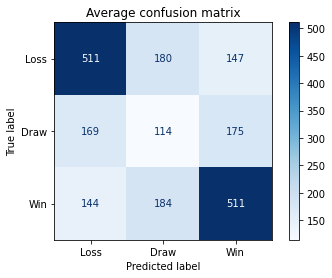

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)


#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities(X_train,X_test)



In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

In [ ]:
X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]  

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.538(0.005) Precision: 0.493(0.006) Recall: 0.493(0.006) F1 Score: 0.493(0.006)


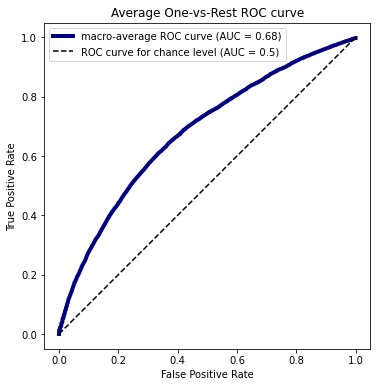

In [ ]:
print_ROC(roc_curves)

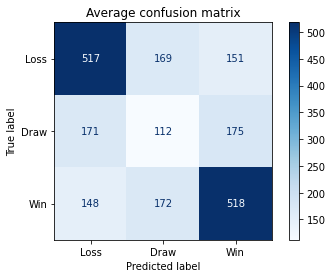

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)


### Polarities only

#### First approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = old_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.497(0.007) Precision: 0.452(0.005) Recall: 0.454(0.005) F1 Score: 0.450(0.005)


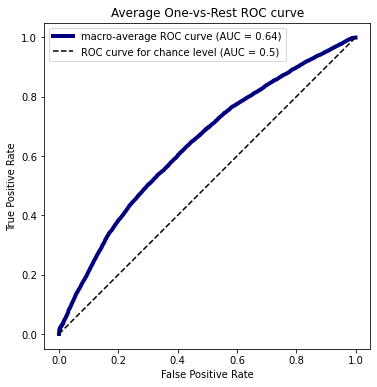

In [ ]:
print_ROC(roc_curves)

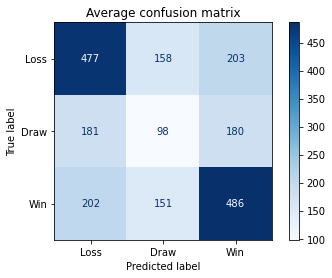

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

#### Second approach

In [ ]:
X_train, Y_train, X_test, Y_test, final_X = getTrainTest(league_df)

In [ ]:
X_train,X_test = new_polarities_only(X_train, X_test)

In [ ]:
X = pd.concat([X_train,X_test])
Y = pd.concat([Y_train,Y_test])

X = X[~X.index.duplicated(keep="first")]  
Y = Y[~Y.index.duplicated(keep="first")]

In [ ]:
X = (X - X.mean()) / X.std()

In [ ]:
matrices = []
accuracies = []
precisions = []
recalls = []
f1s = []
roc_curves = []

for i in range(5):
  inner_results, outer_results, y_scores, y_onehot= nestedCV(classifier, space, 1, X, Y, n=i)
  matrices.append(get_mean_confusion_matrices(inner_results))
  accuracies.append(np.mean([x['acc'] for x in outer_results]))
  precisions.append(np.mean([x['prec'] for x in outer_results]))
  recalls.append(np.mean([x['rec'] for x in outer_results]))
  f1s.append(np.mean([x['f1'] for x in outer_results]))
  roc_curves.append(get_mean_roc(y_scores,y_onehot))


In [ ]:
print("RESULTS:", f'Accuracy: {np.mean(accuracies):.3f}({np.std(accuracies):.3f}) Precision: {np.mean(precisions):.3f}({np.std(precisions):.3f}) Recall: {np.mean(recalls):.3f}({np.std(recalls):.3f}) F1 Score: {np.mean(f1s):.3f}({np.std(f1s):.3f})  ')#non sembra cambiare

RESULTS: Accuracy: 0.521(0.006) Precision: 0.460(0.006) Recall: 0.464(0.005) F1 Score: 0.446(0.007)


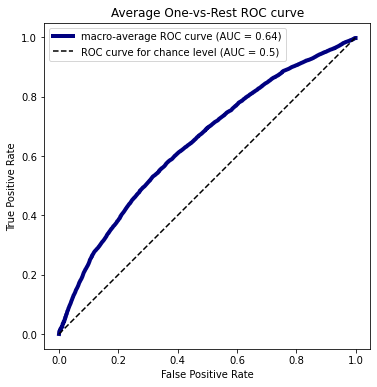

In [ ]:
print_ROC(roc_curves)

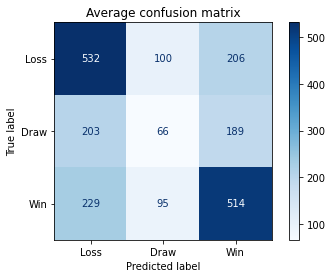

<Figure size 432x432 with 0 Axes>

In [ ]:
print_mean_confusion_matrices_total(matrices)

# Leaderboard prediction

In [ ]:
space = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

classifier = XGBClassifier()
le = LabelEncoder()

In [ ]:
X_train, Y_train, X_test, Y_test = getTrainTestSeason(league_df, 2020)

X_train,X_test = new_polarities(X_train, X_test)

Y_train, Y_test = le.fit_transform(Y_train), le.fit_transform(Y_test)

In [ ]:
model = RandomizedSearchCV(classifier, space, n_iter=1*param_combinations(space), n_jobs=-1, verbose=1)
model.fit(X_train, Y_train)

In [ ]:
model.best_score_

0.6060005150656709

In [ ]:
def simulate_leaderboard(model, league_df, X_test):

  stats = defaultdict(lambda : defaultdict(lambda : 0))

  for index in league_df[league_df.season==2020].index:

    team = league_df.loc[index,'team']
    result = league_df.loc[index,'result']

    stats[team]['w'] += 0 if result != 'W' else 1
    stats[team]['d'] += 0 if result != 'D' else 1
    stats[team]['l'] += 0 if result != 'L' else 1
    
    if len(X_test[X_test.index == index]) >= 1:
      pred = model.predict(X_test[X_test.index == index])

      #print(pred)

      stats[team]['w_p'] += 0 if pred != 2 else 1
      stats[team]['d_p'] += 0 if pred != 1 else 1
      stats[team]['l_p'] += 0 if pred != 0 else 1


  return stats #dovrebbe avere le vittorie etc predette e reali



In [ ]:
teams_stats = simulate_leaderboard(model, league_df, X_test)

In [ ]:
#ACTUAL LEADERBOARD OF SERIE A

leaderboard = pd.DataFrame()
i = 0 
for team in teams_stats:
  points = 3*teams_stats[team]['w']+teams_stats[team]['d']
  leaderboard.loc[i,'team'] = team 
  leaderboard.loc[i,'w'] = teams_stats[team]['w']
  leaderboard.loc[i,'d'] = teams_stats[team]['d']
  leaderboard.loc[i,'l'] = teams_stats[team]['l']
  leaderboard.loc[i,'points'] = points
  i+=1

In [ ]:
leaderboard.sort_values('points',ascending=False)

,team,w,d,l,points
16,inter,27.0,7.0,3.0,88.0
10,juventus,23.0,9.0,6.0,78.0
12,milan,24.0,6.0,7.0,78.0
17,atalanta,23.0,9.0,6.0,78.0
5,napoli,24.0,5.0,9.0,77.0
14,lazio,21.0,5.0,12.0,68.0
3,roma,18.0,9.0,11.0,63.0
8,sassuolo,16.0,11.0,9.0,59.0
11,sampdoria,15.0,7.0,16.0,52.0
2,verona,10.0,13.0,15.0,43.0


In [ ]:
#Predicted leaderboard by model

leaderboard_pred = pd.DataFrame()
i = 0 
for team in teams_stats:
  #print(team)
  points = 3*teams_stats[team]['w_p']+teams_stats[team]['d_p']
  leaderboard_pred.loc[i,'team'] = team 
  leaderboard_pred.loc[i,'w_p'] = teams_stats[team]['w_p']
  leaderboard_pred.loc[i,'d_p'] = teams_stats[team]['d_p']
  leaderboard_pred.loc[i,'l_p'] = teams_stats[team]['l_p']
  leaderboard_pred.loc[i,'points'] = points
  i+=1

In [ ]:
leaderboard_pred.sort_values('points',ascending=False)

,team,w_p,d_p,l_p,points
10,juventus,33.0,2.0,1.0,101.0
16,inter,26.0,7.0,1.0,85.0
12,milan,26.0,6.0,3.0,84.0
17,atalanta,24.0,6.0,6.0,78.0
5,napoli,24.0,3.0,7.0,75.0
14,lazio,24.0,1.0,10.0,73.0
3,roma,22.0,6.0,4.0,72.0
0,fiorentina,15.0,6.0,13.0,51.0
8,sassuolo,14.0,3.0,17.0,45.0
1,torino,13.0,5.0,13.0,44.0
